# Model Based Machine Learning - Used Cars Price Prediction

## Imports

In [1]:
# Uncomment the next line and run the cell to install Pyro for Jupyter Notebook:
#!pip install pyro-ppl

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyro
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
%matplotlib inline


In [3]:
"""Command to create a python file of the notebook (change path as needed):"""""
#c:\Users\cahar\AppData\Local\Programs\Python\Python311\python.exe -m jupyter nbconvert --to script model_based_ml_project.ipynb

'Command to create a python file of the notebook (change path as needed):'

# Data: Description, Preprocessing, and Analysis

In [4]:
# Loading the data and inspect the first rows
df = pd.read_csv('csv_files\car_price_prediction.csv')
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [5]:
# Inspect the dataset: we start with the shape of the dataset, columns, and types
print("Dataset shape: ", df.shape)
print("Columns and Types:")
print(df.dtypes)

Dataset shape:  (19237, 18)
Columns and Types:
ID                    int64
Price                 int64
Levy                 object
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage              object
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags               int64
dtype: object


In [6]:
#check for duplications
df.duplicated().sum()

313

In [7]:
# we will drop duplications and check for missing values
df.drop_duplicates(inplace= True)
df.isnull().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

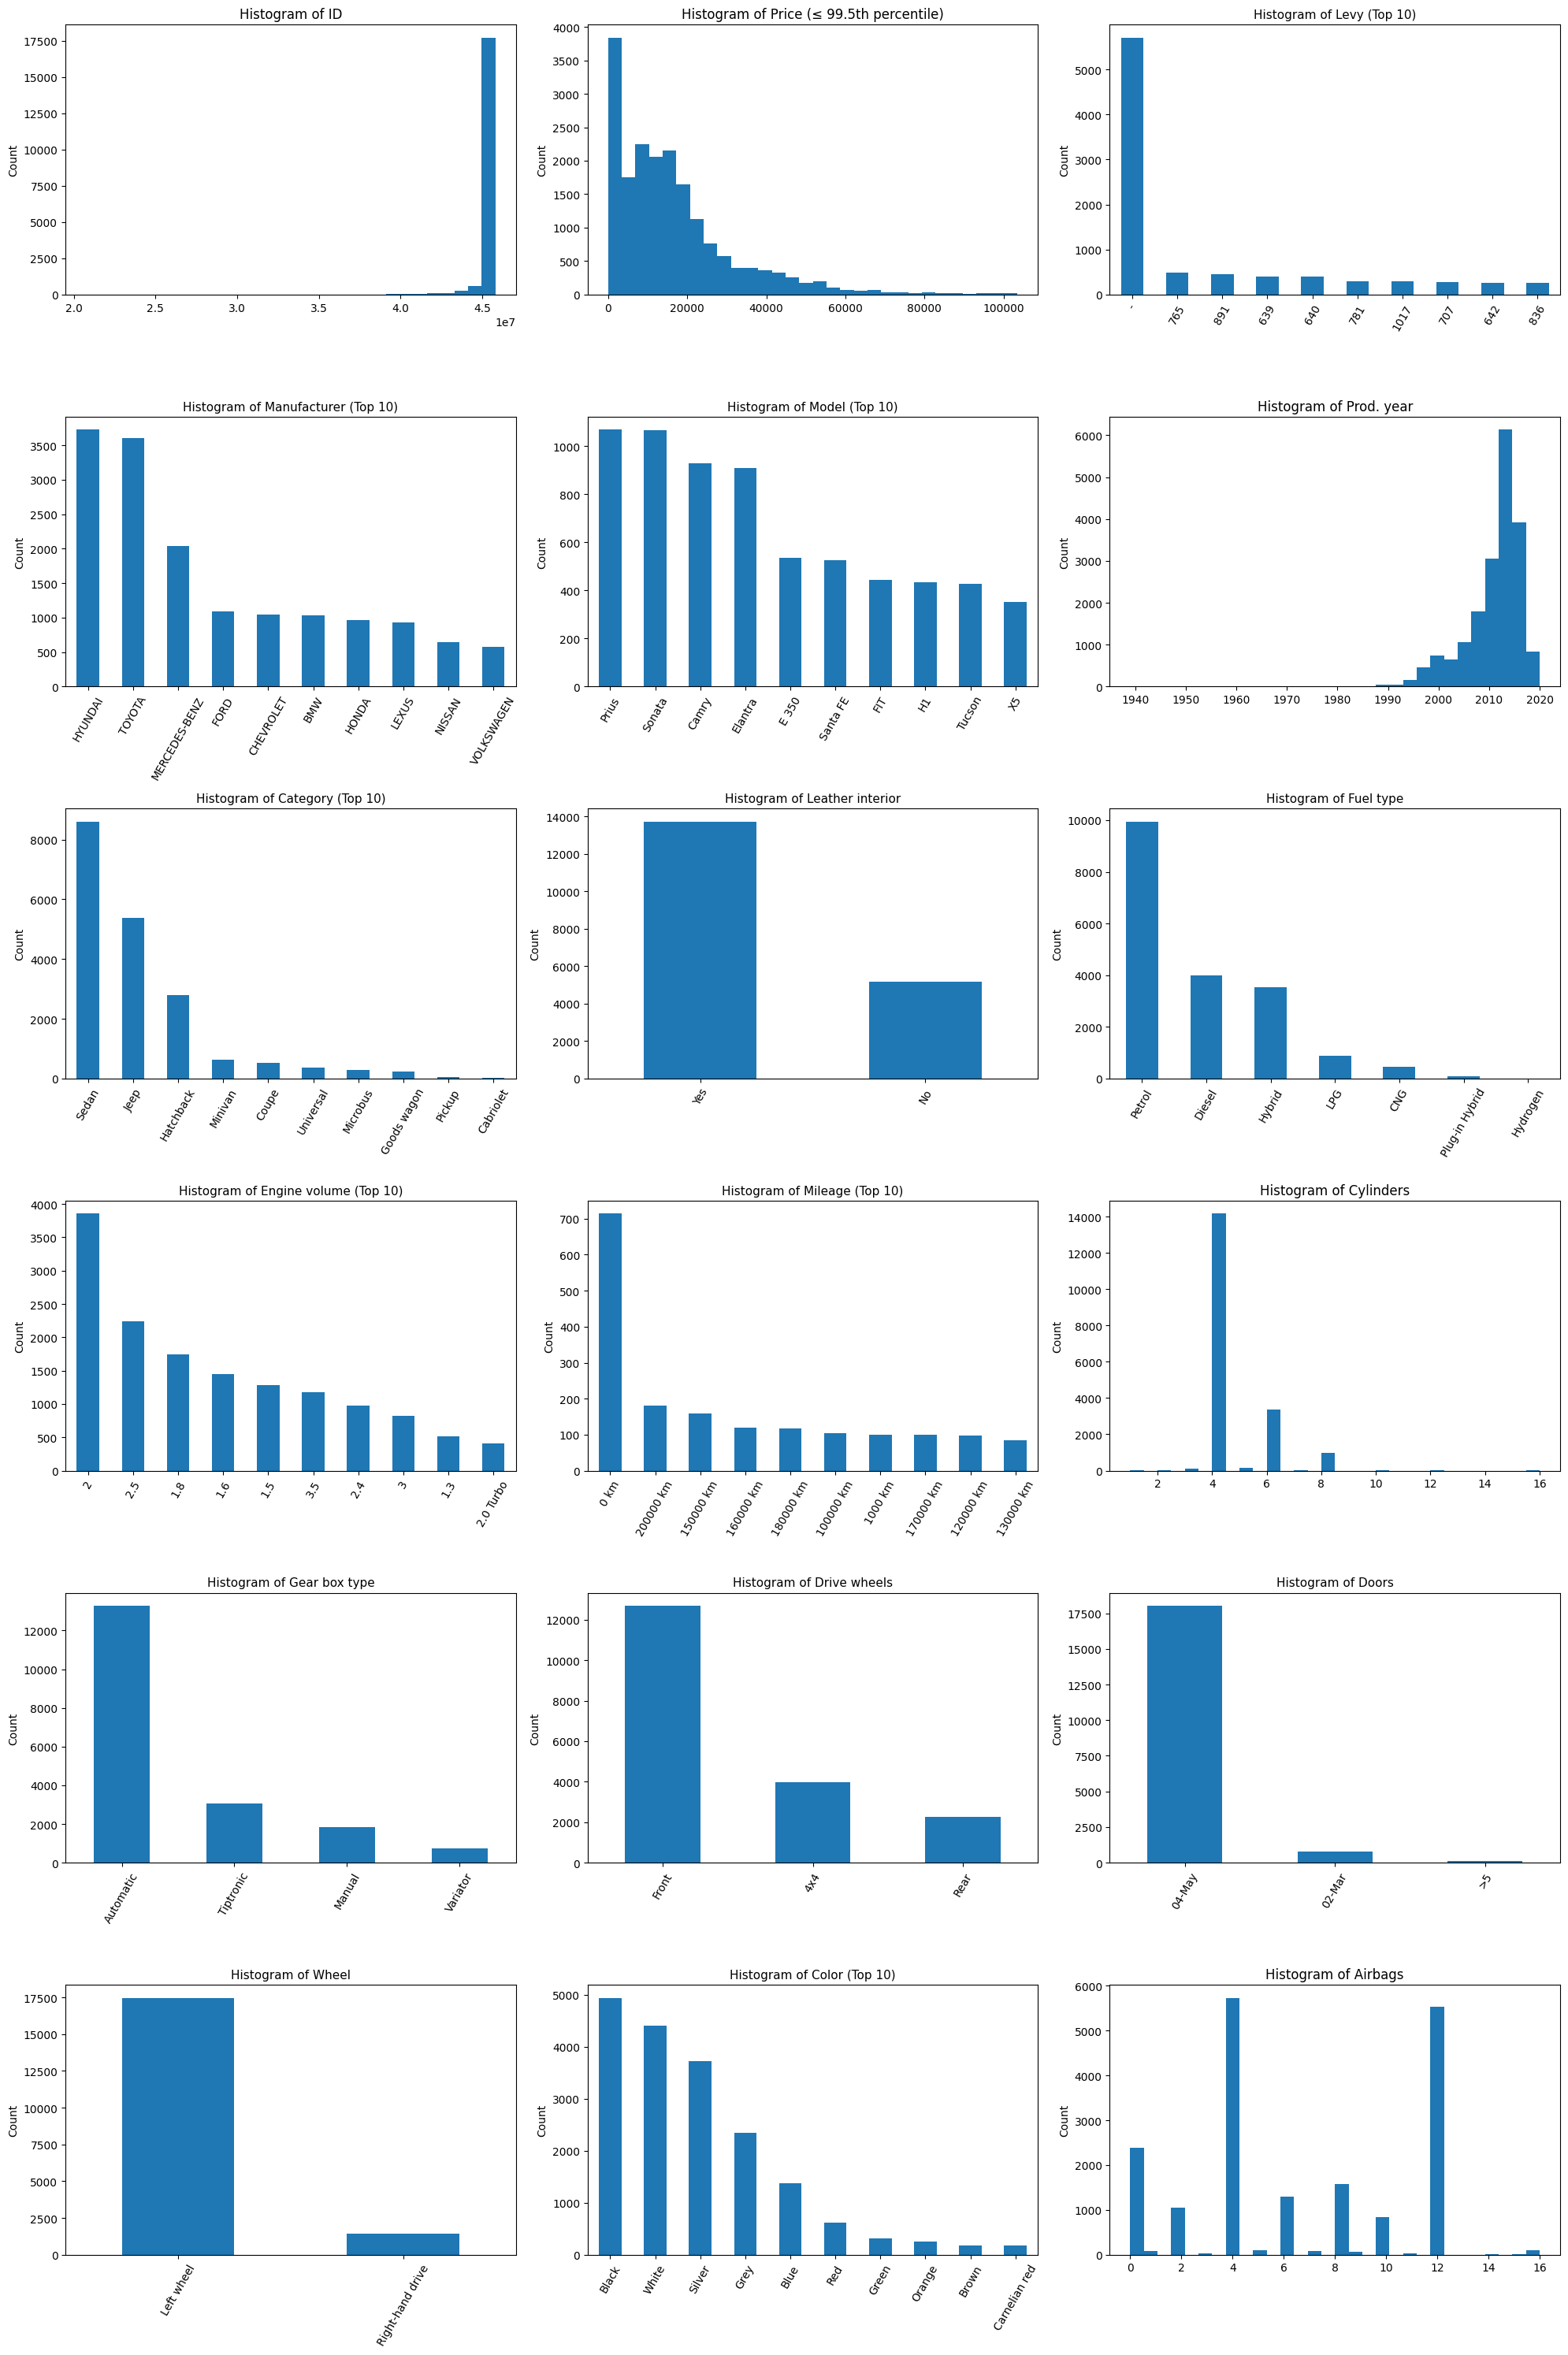

In [ ]:

# Number of columns per row in the plot grid
n_cols = 3
n_rows = -(-len(df.columns) // n_cols)  # Ceiling division

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

# Plot each feature
for i, col in enumerate(df.columns):
    ax = axes[i]
    try:
        if col == "Price":
            price_data = df[col].astype(float)
            upper_limit = price_data.quantile(0.999)
            price_data = price_data[price_data <= upper_limit]
            price_data.plot(kind='hist', bins=30, ax=ax)
            ax.set_title(f"Histogram of {col} (≤ 99.9th percentile)")
        else:
            df[col].astype(float).plot(kind='hist', bins=30, ax=ax)
            ax.set_title(f"Histogram of {col}") 
    except:
        # For categorical data, show only the top 20 most frequent categories
        vc = df[col].value_counts(dropna=True)
        vc[:10].plot(kind='bar', ax=ax)
        ax.set_title(f"Histogram of {col} (Top 10)" if df.nunique()[col]>=10 else f"Histogram of {col}" , fontsize=11)
        ax.tick_params(axis='x', rotation=60)
    ax.set_xlabel('')
    ax.set_ylabel('Count')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
fig.savefig(r'images\histograms_dataframe.png', bbox_inches='tight')
plt.show()

As expected, there are many values that need preprocessing, and we can also ignore some features that we believe that do not have influence over the price (e.g. Steering wheels side, color and ID). Other features need to be treated differently: for example, milage contains the string "KM". This should be removed and the values should contain only the numerical value. Other features such as engine volume, contain some additional information about the engine like "turbo" - which we will split into another binary feature that will contain values 0 or 1 for whether the engine is a turbo engine (0 if not, else 1). Additionally, many of the features are categorical, hence we will use one-hot encoding or ordinal encoding to fix them and fit them to a regression model.

Another desicion is to drop the attribute "model". This is due to high cardinality, as we have 1590 unique values (see the list below). Moreover, the "model" feature can be captured by other features of the car. i.e. the common sense is saying that the model is a major factor in the price, however, we believe that the rest of the features will capture the quality of a certain model (e.g. engine volume, leather seats, number of airbags etc). 

In [9]:
# Check the number of unique values of each column
df.nunique()

ID                  18924
Price                2315
Levy                  559
Manufacturer           65
Model                1590
Prod. year             54
Category               11
Leather interior        2
Fuel type               7
Engine volume         107
Mileage              7687
Cylinders              13
Gear box type           4
Drive wheels            3
Doors                   3
Wheel                   2
Color                  16
Airbags                17
dtype: int64

In [10]:
# Drop irrelevant columns -4 columns
df_cleaned = df.drop(columns=['ID', 'Model', 'Color', 'Wheel','Doors'])

# Levy to numeric
df_cleaned['Levy'] = df_cleaned['Levy'].replace('-', pd.NA)
df_cleaned['Levy'] = pd.to_numeric(df_cleaned['Levy'], errors='coerce')

#Leather interior to binary
df_cleaned['Leather interior'] = df_cleaned['Leather interior'].map({'Yes': 1, 'No': 0})

In [11]:
#check the unique values and additional strings in engine volume
engine_volume_values = df_cleaned['Engine volume'].unique()
sorted(engine_volume_values)

['0',
 '0.1',
 '0.2',
 '0.2 Turbo',
 '0.3',
 '0.3 Turbo',
 '0.4',
 '0.4 Turbo',
 '0.5',
 '0.6',
 '0.6 Turbo',
 '0.7',
 '0.7 Turbo',
 '0.8',
 '0.8 Turbo',
 '0.9',
 '1',
 '1.0 Turbo',
 '1.1',
 '1.1 Turbo',
 '1.2',
 '1.2 Turbo',
 '1.3',
 '1.3 Turbo',
 '1.4',
 '1.4 Turbo',
 '1.5',
 '1.5 Turbo',
 '1.6',
 '1.6 Turbo',
 '1.7',
 '1.7 Turbo',
 '1.8',
 '1.8 Turbo',
 '1.9',
 '1.9 Turbo',
 '2',
 '2.0 Turbo',
 '2.1',
 '2.1 Turbo',
 '2.2',
 '2.2 Turbo',
 '2.3',
 '2.3 Turbo',
 '2.4',
 '2.4 Turbo',
 '2.5',
 '2.5 Turbo',
 '2.6',
 '2.7',
 '2.7 Turbo',
 '2.8',
 '2.8 Turbo',
 '2.9',
 '2.9 Turbo',
 '20',
 '3',
 '3.0 Turbo',
 '3.1',
 '3.2',
 '3.2 Turbo',
 '3.3',
 '3.4',
 '3.5',
 '3.5 Turbo',
 '3.6',
 '3.6 Turbo',
 '3.7',
 '3.7 Turbo',
 '3.8',
 '3.9',
 '4',
 '4.0 Turbo',
 '4.2',
 '4.2 Turbo',
 '4.3',
 '4.4',
 '4.4 Turbo',
 '4.5',
 '4.5 Turbo',
 '4.6',
 '4.6 Turbo',
 '4.7',
 '4.7 Turbo',
 '4.8',
 '4.8 Turbo',
 '5',
 '5.0 Turbo',
 '5.2',
 '5.3',
 '5.4',
 '5.4 Turbo',
 '5.5',
 '5.5 Turbo',
 '5.6',
 '5.7',
 '5.7

In [12]:
# Create 'Turbo' binary column
df_cleaned['Turbo'] = df_cleaned['Engine volume'].str.contains('Turbo').astype(int)

# Extract numeric part of engine volume
df_cleaned['Engine volume'] = df_cleaned['Engine volume'].str.replace(' Turbo', '', regex=False).astype(float)

In [13]:
#Drop 'Fuel type'
df_cleaned = df_cleaned.drop(columns=['Fuel type'])

# Mileage - remove ' km' and convert to numeric
df_cleaned['Mileage'] = df_cleaned['Mileage'].str.replace(' km', '', regex=False).str.replace(',', '')
df_cleaned['Mileage'] = pd.to_numeric(df_cleaned['Mileage'], errors='coerce')

# Cylinders and Airbags - numeric
df_cleaned['Cylinders'] = pd.to_numeric(df_cleaned['Cylinders'], errors='coerce')
df_cleaned['Airbags'] = pd.to_numeric(df_cleaned['Airbags'], errors='coerce')

# Preprocessing production year to Age
dataset_year = 2022 #The year that the used car dataset was published.
df_cleaned['Age'] = dataset_year - df_cleaned['Prod. year']
df_cleaned = df_cleaned.drop(columns=['Prod. year'])

# Preview the cleaned dataframe
df_cleaned.head()
print(df_cleaned.columns)


Index(['Price', 'Levy', 'Manufacturer', 'Category', 'Leather interior',
       'Engine volume', 'Mileage', 'Cylinders', 'Gear box type',
       'Drive wheels', 'Airbags', 'Turbo', 'Age'],
      dtype='object')


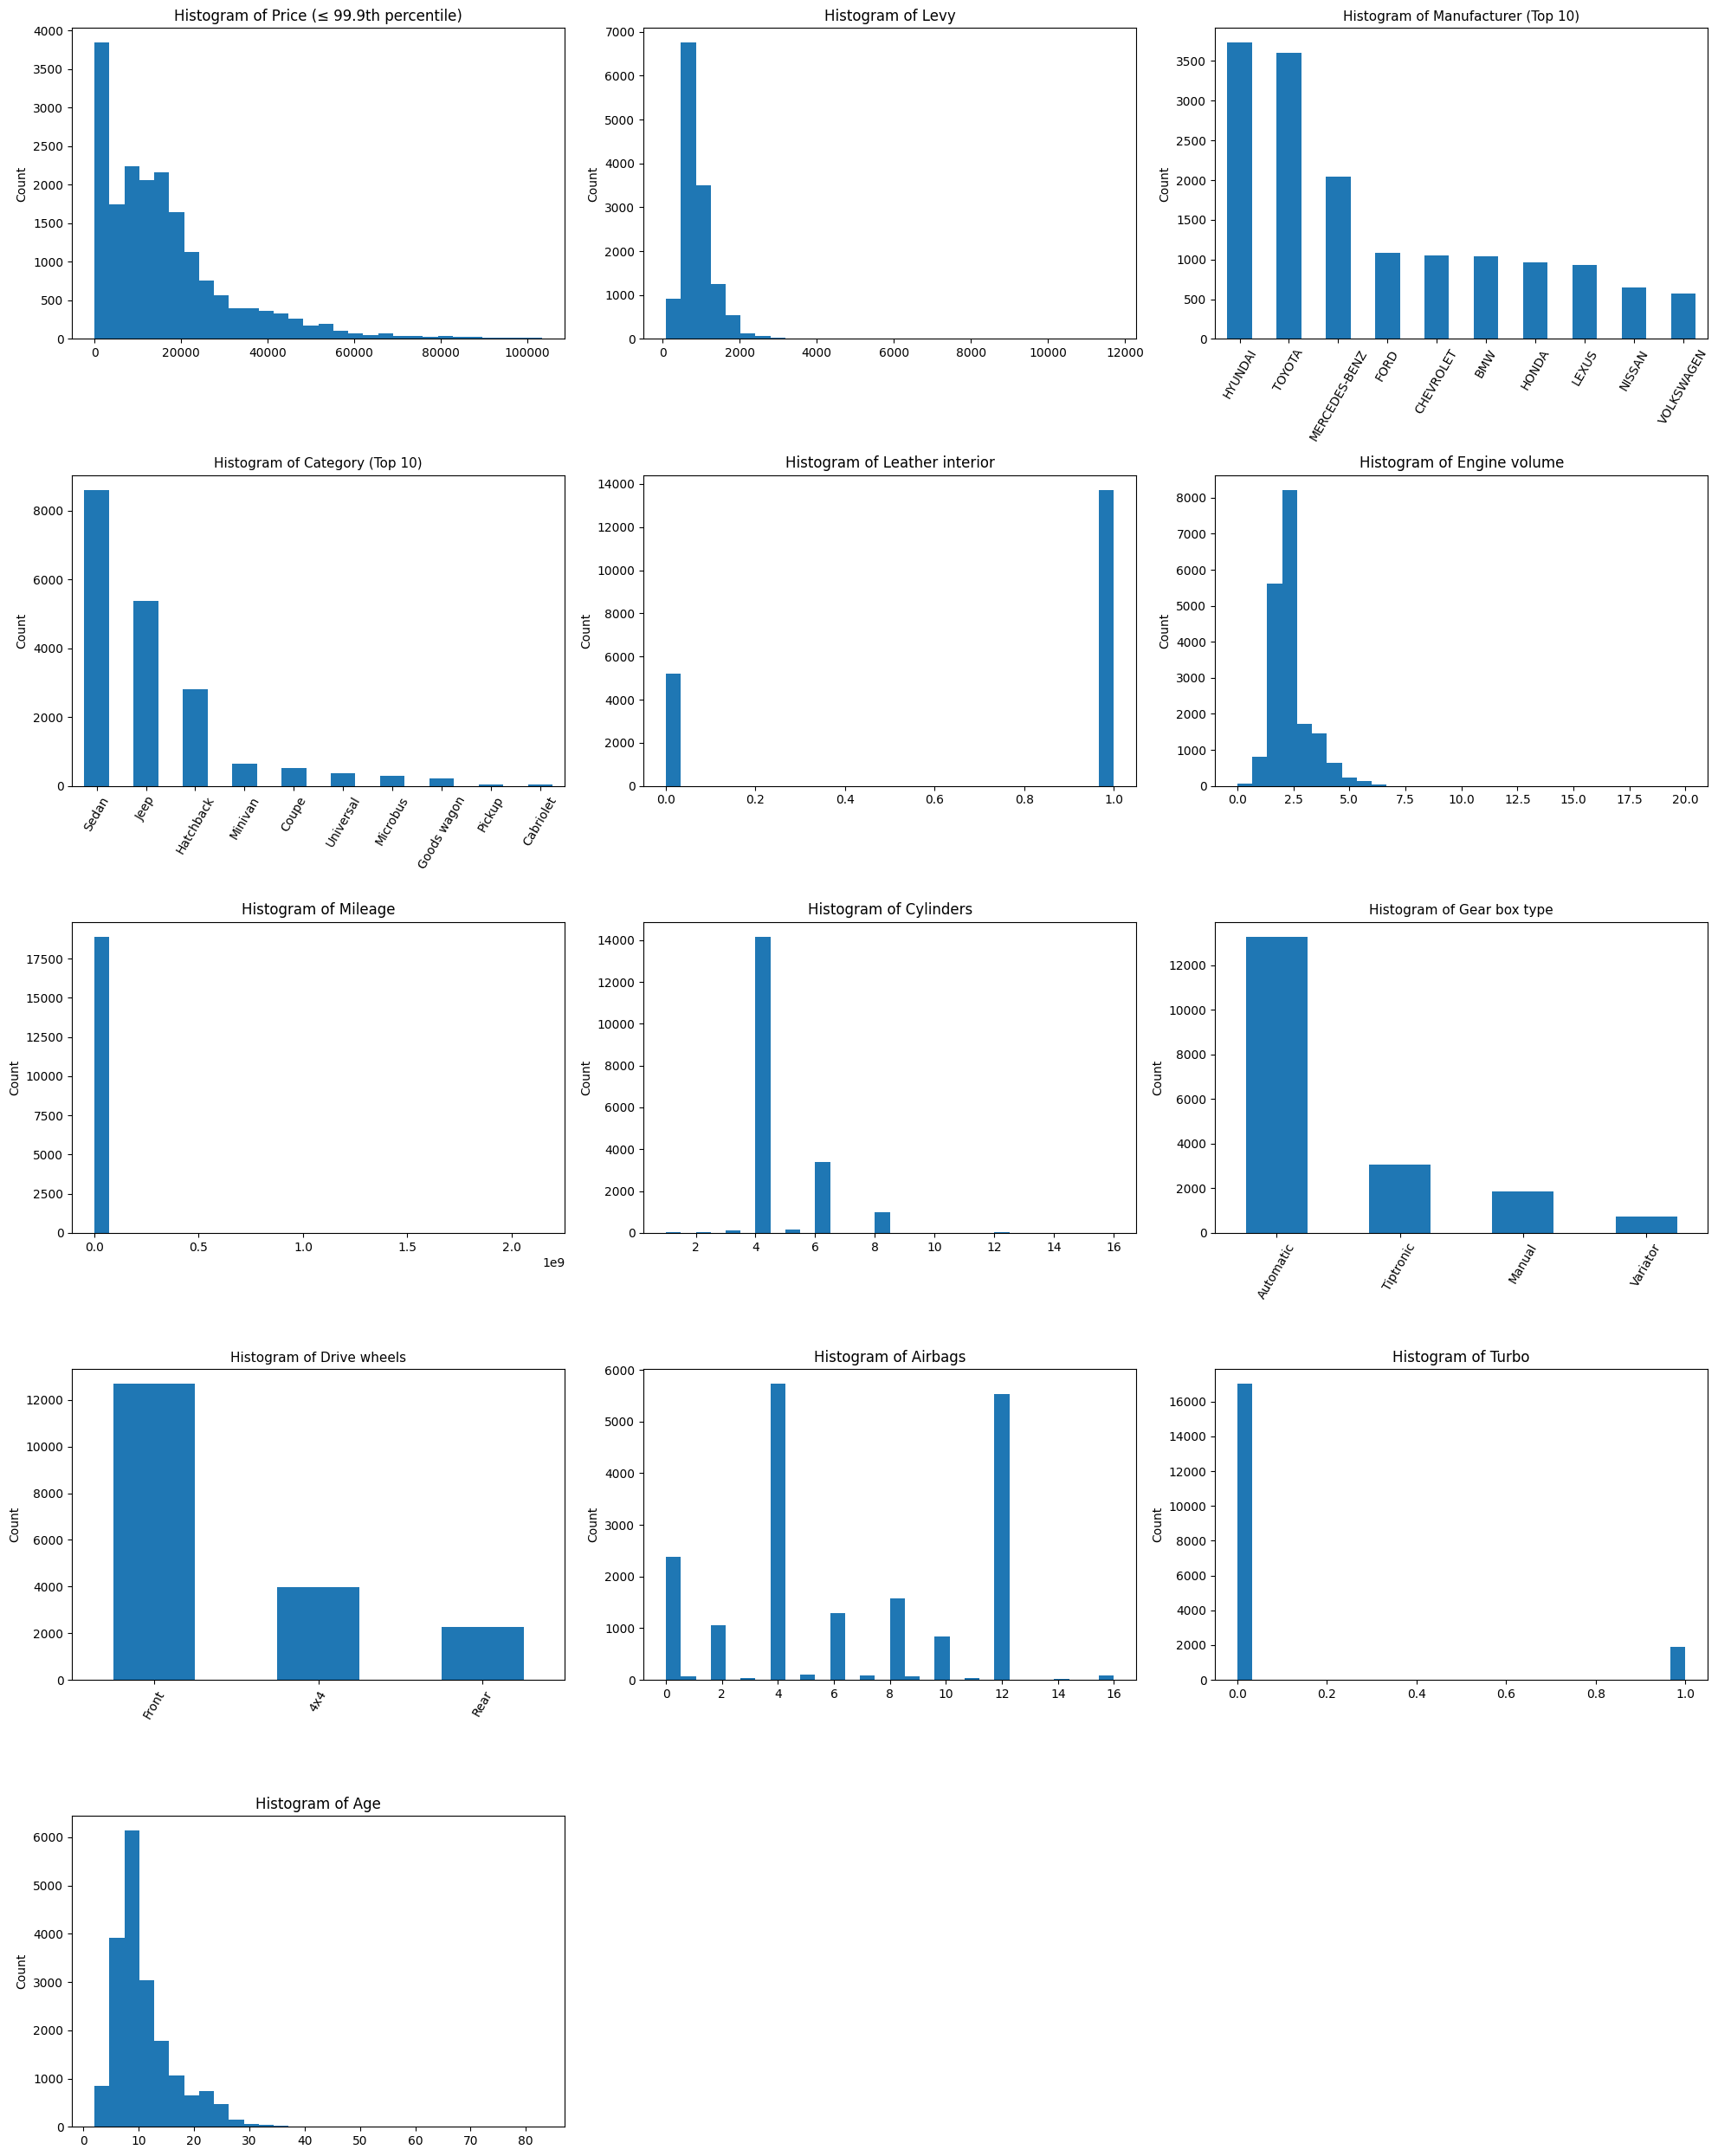

In [ ]:

# Number of columns per row in the plot grid
n_cols = 3
n_rows = -(-len(df_cleaned.columns) // n_cols)  # Ceiling division

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

# Plot each feature
for i, col in enumerate(df_cleaned.columns):
    ax = axes[i]
    try:
        if col == "Price":
            price_data = df_cleaned[col].astype(float)
            upper_limit = price_data.quantile(0.999)
            price_data = price_data[price_data <= upper_limit]
            price_data.plot(kind='hist', bins=30, ax=ax)
            ax.set_title(f"Histogram of {col} (≤ 99.9th percentile)")
        else:
            df_cleaned[col].astype(float).plot(kind='hist', bins=30, ax=ax)
            ax.set_title(f"Histogram of {col}")
    except:
        vc = df_cleaned[col].value_counts(dropna=True)
        vc[:10].plot(kind='bar', ax=ax)
        ax.set_title(f"Histogram of {col} (Top 10)" if df_cleaned.nunique()[col] >= 10 else f"Histogram of {col}", fontsize=11)
        ax.tick_params(axis='x', rotation=60)
    ax.set_xlabel('')
    ax.set_ylabel('Count')
   

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
fig.savefig(r'images\histograms_dataframe_cleaned.png', bbox_inches='tight')
plt.show()

In [15]:
print("Descriptive Statistics:")
df_cleaned.describe().T

Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
Price,18924.0,1.858744e+04,1.921356e+05,1.0,5331.00,13172.0,22063.00,2.630750e+07
Levy,13215.0,9.062992e+02,4.632969e+02,87.0,640.00,781.0,1058.00,1.171400e+04
Leather interior,18924.0,7.255866e-01,4.462300e-01,0.0,0.00,1.0,1.00,1.000000e+00
Engine volume,18924.0,2.306251e+00,8.775910e-01,0.0,1.80,2.0,2.50,2.000000e+01
Mileage,18924.0,1.555373e+06,4.880221e+07,0.0,70195.75,126400.0,189119.75,2.147484e+09
Cylinders,18924.0,4.580216e+00,1.200223e+00,1.0,4.00,4.0,4.00,1.600000e+01
Airbags,18924.0,6.568379e+00,4.322323e+00,0.0,4.00,6.0,12.00,1.600000e+01
Turbo,18924.0,9.997886e-02,2.999797e-01,0.0,0.00,0.0,0.00,1.000000e+00
Age,18924.0,1.108576e+01,5.665749e+00,2.0,7.00,10.0,13.00,8.300000e+01


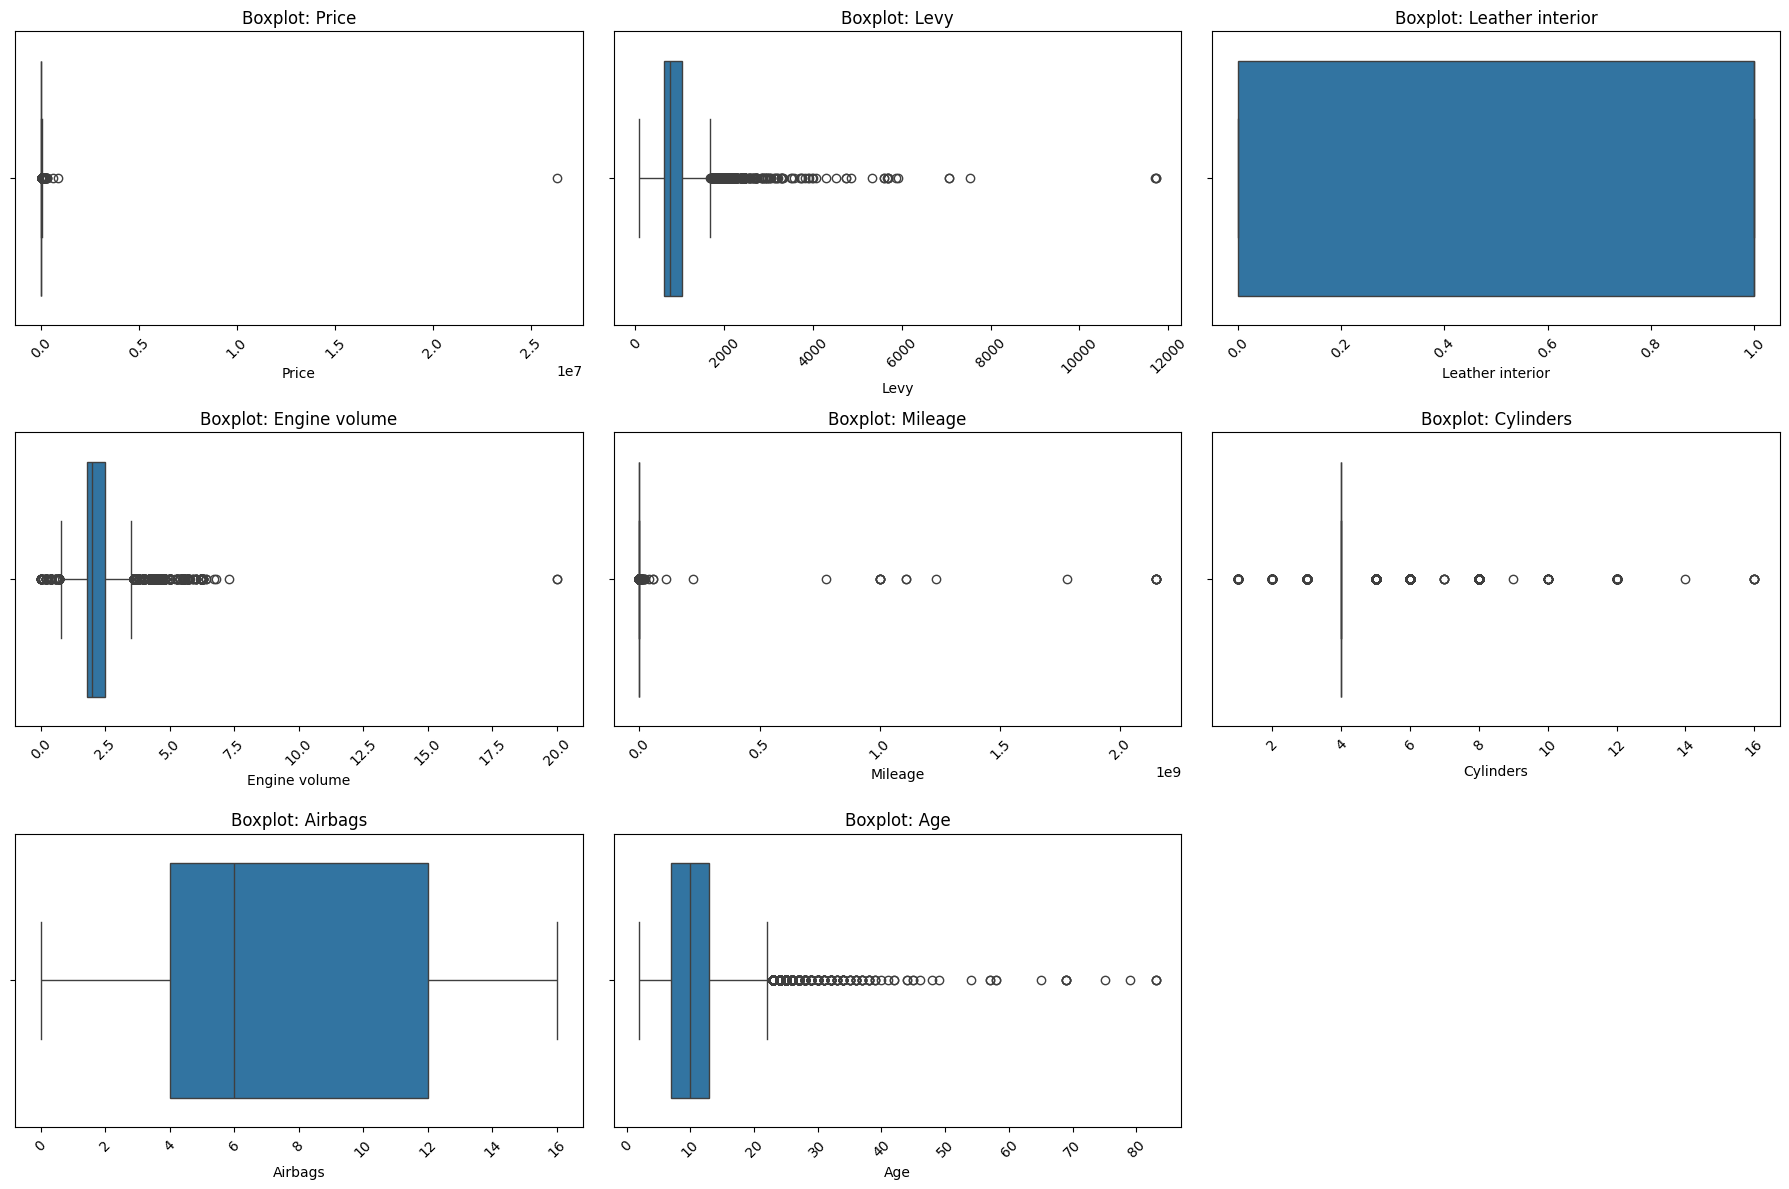

In [16]:
# Select only numerical columns
numeric_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns

# Set up plot
n_cols = 3
n_rows = -(-len(numeric_cols) // n_cols)  # Ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

# Create boxplot for each numeric feature
for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df_cleaned, x=col, ax=axes[i])
    axes[i].set_title(f'Boxplot: {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
fig.savefig(r'images\boxplots.png', bbox_inches='tight')
plt.show()

It looks like the data for the price and mileage, Levy and age, got some outliers the influence the distribution. We will inspect the prices further:

In [17]:
print(df_cleaned['Price'].describe())

print(" ")

Q1 = df_cleaned['Price'].quantile(0.25)
Q3 = df_cleaned['Price'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

print("Upper bound:", upper_bound)

count    1.892400e+04
mean     1.858744e+04
std      1.921356e+05
min      1.000000e+00
25%      5.331000e+03
50%      1.317200e+04
75%      2.206300e+04
max      2.630750e+07
Name: Price, dtype: float64
 
Upper bound: 47161.0


In [18]:
print(f"Number of entries: {len(df_cleaned[df_cleaned['Price'] > 50000])}")

Number of entries: 908


In [19]:
print(f"Number of entries: {len(df_cleaned[df_cleaned['Price'] < 2000])}")

Number of entries: 3141


There are 908 records of cars that their price is greater than 50,000. Also, 3,141 cars that are priced under 2,000. We will drop them, and plot the price distribution again:

In [20]:
df_cleaned = df_cleaned[(df_cleaned['Price'] >= 2000) & (df_cleaned['Price'] <= 50000)]

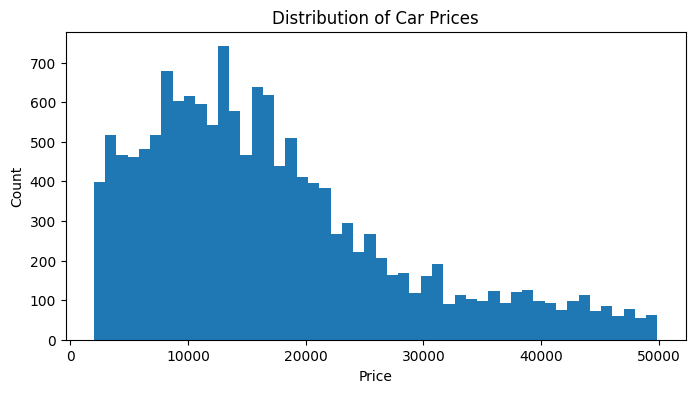

In [21]:
# Plot without those extreme prices
plt.figure(figsize=(8, 4))
plt.hist(df_cleaned['Price'], bins=50)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Distribution of Car Prices')
plt.show()

Due to heavy skewness of the prices, we will try to plot the distribution in it's log-values. It might help us later in the baseline model, to improve linearity between the predicted variable and the predictors.

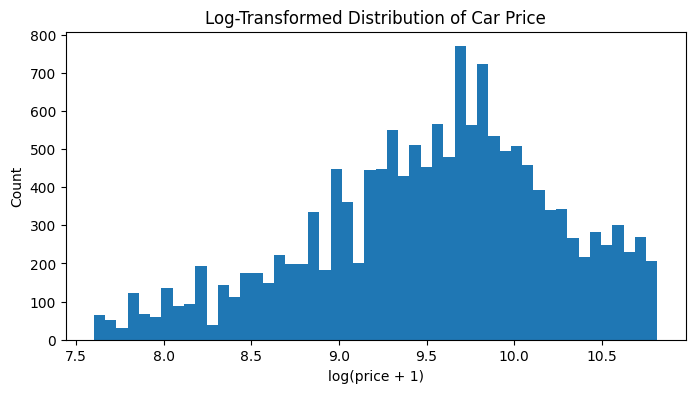

In [22]:
plt.figure(figsize=(8,4))
plt.hist(np.log1p(df_cleaned['Price']), bins=50)
plt.xlabel('log(price + 1)')
plt.ylabel('Count')
plt.title('Log-Transformed Distribution of Car Price')
plt.show()

In [23]:
#we do the same for mileage:
print(df_cleaned['Mileage'].describe())

print(" ")

Q1 = df_cleaned['Mileage'].quantile(0.25)
Q3 = df_cleaned['Mileage'].quantile(0.75)
IQR = Q3 - Q1
print("upper bound: ", Q3 + 1.5 * IQR)

count    1.487500e+04
mean     1.717180e+06
std      5.135177e+07
min      0.000000e+00
25%      7.200000e+04
50%      1.260000e+05
75%      1.840000e+05
max      2.147484e+09
Name: Mileage, dtype: float64
 
upper bound:  352000.0


since the upper bound for mileage is 352,000, we will check for removing a reasonable number of recordings, to avoid removing to much rows:

In [24]:
print(f"Number of entries: {len(df_cleaned[df_cleaned['Mileage'] > 370000])}")

Number of entries: 465


In [25]:
df_cleaned = df_cleaned[df_cleaned['Mileage'] <= 370000]


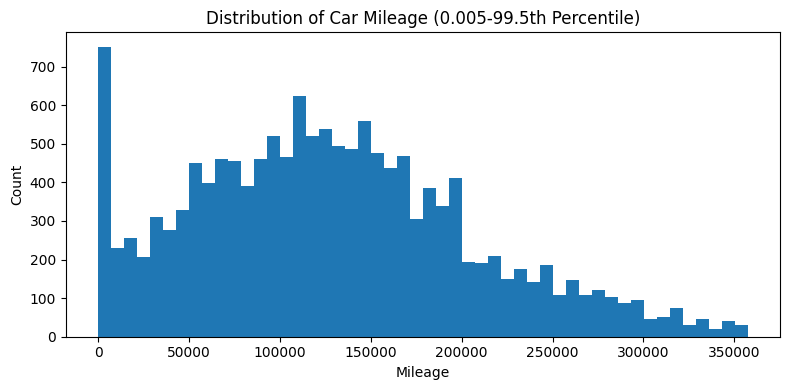

In [26]:
lower = df_cleaned['Mileage'].quantile(0.005)
upper = df_cleaned['Mileage'].quantile(0.995)

plt.figure(figsize=(8,4))
plt.hist(df_cleaned['Mileage'][(df_cleaned['Mileage'] >= lower) & (df_cleaned['Mileage'] <= upper)], bins=50)
plt.xlabel('Mileage')
plt.ylabel('Count')
plt.title('Distribution of Car Mileage (0.005-99.5th Percentile)')
plt.tight_layout()
plt.show()


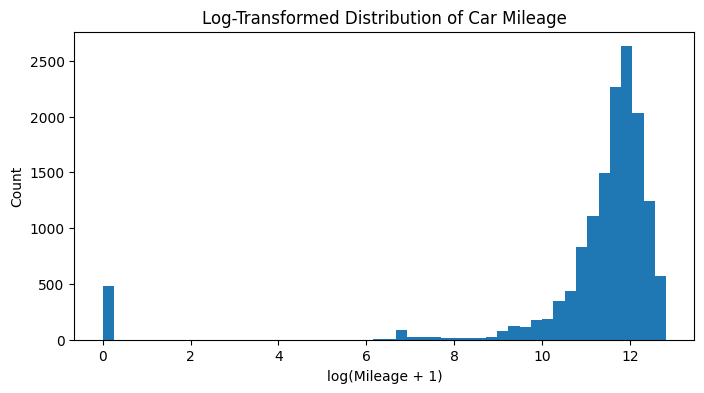

In [27]:
plt.figure(figsize=(8,4))
plt.hist(np.log1p(df_cleaned['Mileage']), bins=50)
plt.xlabel('log(Mileage + 1)')
plt.ylabel('Count')
plt.title('Log-Transformed Distribution of Car Mileage')
plt.show()

In [28]:
# another check for our features and missing values:
print("Dataset shape: ", df_cleaned.shape)
print("Columns and Types:")
print(df_cleaned.dtypes)
print(" ")
print("Missing Values:")
df_cleaned.isnull().sum()

Dataset shape:  (14410, 13)
Columns and Types:
Price                 int64
Levy                float64
Manufacturer         object
Category             object
Leather interior      int64
Engine volume       float64
Mileage               int64
Cylinders           float64
Gear box type        object
Drive wheels         object
Airbags               int64
Turbo                 int32
Age                   int64
dtype: object
 
Missing Values:


Price                  0
Levy                4889
Manufacturer           0
Category               0
Leather interior       0
Engine volume          0
Mileage                0
Cylinders              0
Gear box type          0
Drive wheels           0
Airbags                0
Turbo                  0
Age                    0
dtype: int64

We can still see some missing values for the Levy. Levy generally refers to a tax or fee imposed by the government based on characteristics of the vehicle. Levy is influenced by the cars features like engine volume, age, vehicle type etc. We will impute missing data for levy based on engine volume and category - we will find the median value for engine volume and category and fill the missing levy based on this value.

In [29]:
group_medians = df_cleaned.groupby(['Engine volume', 'Category'])['Levy'].median()
group_medians.isnull().sum()

91

In [30]:
#Since there are some in group_median that are NaN, 
# we will create another group, a more general group_medians, this time by engine volume only:
engine_volume_medians = df_cleaned.groupby('Engine volume')['Levy'].median()
print("Number of engine_volume_medians NaNs: ", engine_volume_medians.isnull().sum())

# There are still NaNs, hence we will create a global median for the rest
global_median_levy = df_cleaned['Levy'].median()

Number of engine_volume_medians NaNs:  8


In [31]:
def impute_levy(row):
    if pd.isnull(row['Levy']):
        key = (row['Engine volume'], row['Category']) # first group_median
        levy_value = group_medians.get(key, np.nan)
        
        if pd.isnull(levy_value):  # If group_median not found, use engine_volume_medians
            levy_value = engine_volume_medians.get(row['Engine volume'], np.nan)
            
        if pd.isnull(levy_value):  # If not found, use global_median_levy
            levy_value = global_median_levy
            
        return levy_value
    return row['Levy']

In [32]:
# applying the imputation
# we will use the "regular" imputation for df_baseline, 
# because maybe later we will use different approach for imputation
df_cleaned['Levy'] = df_cleaned.apply(impute_levy, axis=1)

In [33]:
# Checking again for missing values after the data cleansing
df_cleaned.isnull().sum()

Price               0
Levy                0
Manufacturer        0
Category            0
Leather interior    0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Airbags             0
Turbo               0
Age                 0
dtype: int64

Now it looks like we are done with the missing values. We will proceed with outliers clean up:

In [34]:
columns_to_check = ['Levy', 'Engine volume', 'Airbags', 'Cylinders', 'Age']

for col in columns_to_check:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = ((df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)).sum()
    total = df_cleaned[col].shape[0]
    
    print(f"{col}: {outliers} outliers ({round(100 * outliers / total, 2)}%) — bounds: [{lower_bound:.1f}, {upper_bound:.1f}]")

Levy: 849 outliers (5.89%) — bounds: [49.5, 1621.5]
Engine volume: 600 outliers (4.16%) — bounds: [0.3, 3.8]
Airbags: 0 outliers (0.0%) — bounds: [-5.0, 19.0]
Cylinders: 3139 outliers (21.78%) — bounds: [4.0, 4.0]
Age: 643 outliers (4.46%) — bounds: [-1.0, 23.0]


It doesn't look like much outliers. We can remove them, except Cylinders, that we will clean a certain and logical range:

In [35]:
df_cleaned = df_cleaned[df_cleaned['Levy'] <= 1584]
df_cleaned = df_cleaned[df_cleaned['Engine volume'] <= 3.8]
df_cleaned = df_cleaned[(df_cleaned['Cylinders'] >= 2) & (df_cleaned['Cylinders'] <= 12)]
df_cleaned = df_cleaned[(df_cleaned['Age'] >= 2) & (df_cleaned['Age'] <= 26)]

In [36]:
df_baseline = df_cleaned.copy()

We still have some features remained to encode:

* **Manufacturer** - Since we believe that there is a strong correlation between the brand and the price, we will encode this by ranking the average price per manufacturer. This captures the average value impact of each manufacturer on price, which makes intuitive sense (e.g. Mercedes vs. Hyundai). It will also will help us to reduce cardinality to a single numeric column, unlike one-hot encoding. However, we're familiar with this problematic feature transformation since we are encoding the target variable. Instead of assigning each manufacturer a unique rank, we will group them into price-based ranges that will hopefully prevent over-fitting and reduces sensitivity to small price differences between manufacturers.
* **Category** - We will check whether to use dummy variables or ordinal values.
* **Gear-Box Type** - We will check whether to use dummy variables or ordinal values.
* **Drive Wheels** - We will check whether to use dummy variables or ordinal values.

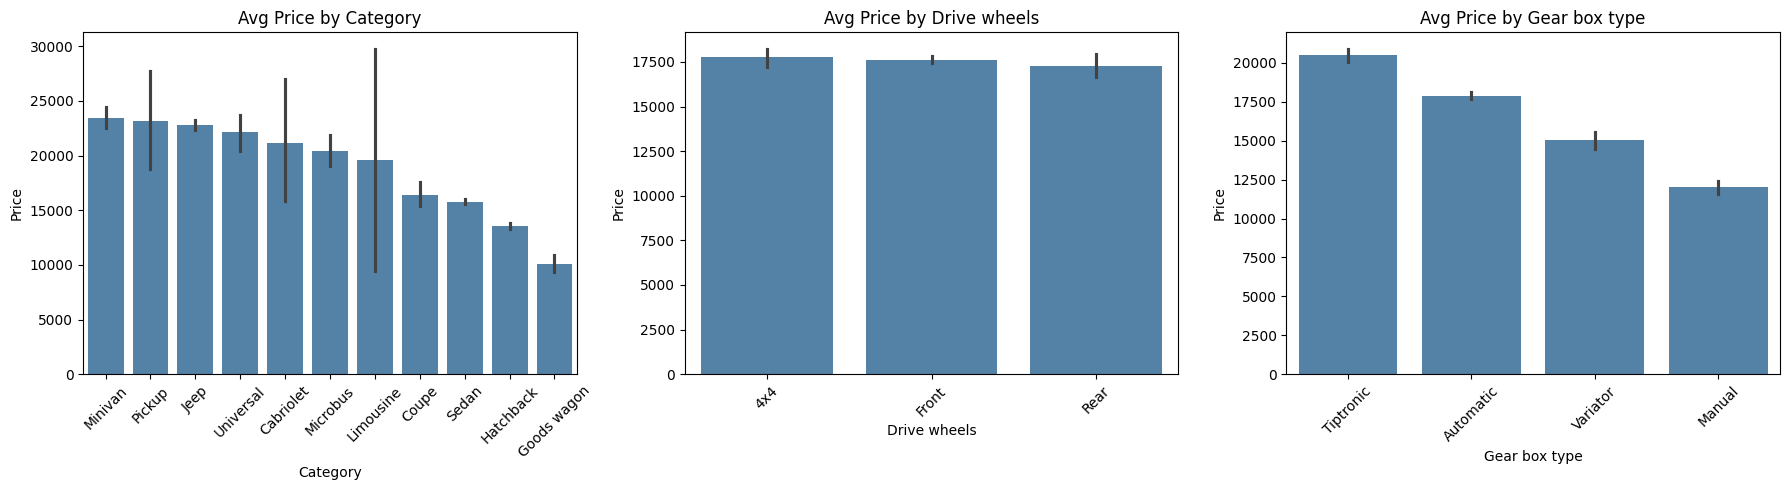

In [37]:
# before proceeding to the last 3 variables, we'll check if there is some correlation between the price
# and those variable. If there is, we would prefer to transform them into a ordinal variable
# rather than one-hot encoding

avg_price_by_category = df_baseline.groupby('Category')['Price'].mean().sort_values(ascending=False)
avg_price_by_gear = df_baseline.groupby('Gear box type')['Price'].mean().sort_values(ascending=False)
avg_price_by_Drive_wheels = df_baseline.groupby('Drive wheels')['Price'].mean().sort_values(ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

sns.barplot(x='Category', y='Price', data=df_baseline, color='steelblue', order=avg_price_by_category.index, ax=axes[0])
axes[0].set_title('Avg Price by Category')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x='Drive wheels', y='Price', data=df_baseline, color='steelblue', order=avg_price_by_Drive_wheels.index, ax=axes[1])
axes[1].set_title('Avg Price by Drive wheels')
axes[1].tick_params(axis='x', rotation=45)

sns.barplot(x='Gear box type', y='Price', data=df_baseline, color='steelblue', order=avg_price_by_gear.index, ax=axes[2])
axes[2].set_title('Avg Price by Gear box type')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
fig.savefig(r'images\categorical_vars.png', bbox_inches='tight')
plt.show()

The three bar plots above show the average car price for each category within the variables Category, Gear box type, and Drive wheels. These plots reveal the patterns in how these features relate to the target variable (Price):

* Category: There is a clear ranking among vehicle types. High-priced categories like Pickup, Cabriolet, and jeep, consistently outperform lower-end types like Goods wagon and Hatchback.

* Gear box type: Average prices decrease consistently from Tiptronic to Manual, indicating a strong ordinal relationship. This also corresponds to common knowledge that e.g. automatic car is more expenssive than manual car.

* Drive wheels: Since differences are smaller, we will use one-hot encoding.

Given these ordered relationships with price, it's appropriate to encode these Category and Gear box type variables as ordinal values, rather than one-hot encoding. For Drive wheels we will use one-hot encoding since the price differences are not that significant. This approach reduces dimensionality while preserving the underlying value hierarchy these features represent.

In [38]:
# Rank encoding for Category
avg_price_by_category = df_baseline.groupby('Category')['Price'].mean().sort_values()
category_rank = avg_price_by_category.rank(method='first').astype(int)
df_baseline['Category_encoded'] = df_baseline['Category'].map(category_rank)

# Rank encoding for Gear box type
avg_price_by_gear = df_baseline.groupby('Gear box type')['Price'].mean().sort_values()
gearbox_rank = avg_price_by_gear.rank(method='first').astype(int)
df_baseline['GearBox_encoded'] = df_baseline['Gear box type'].map(gearbox_rank)

# One-hot encoding for Drive wheels
drive_dummies = pd.get_dummies(df_baseline['Drive wheels'], prefix='Drive')
df_baseline = pd.concat([df_baseline, drive_dummies], axis=1)

We will check correlations again, now that the data is fully ready:

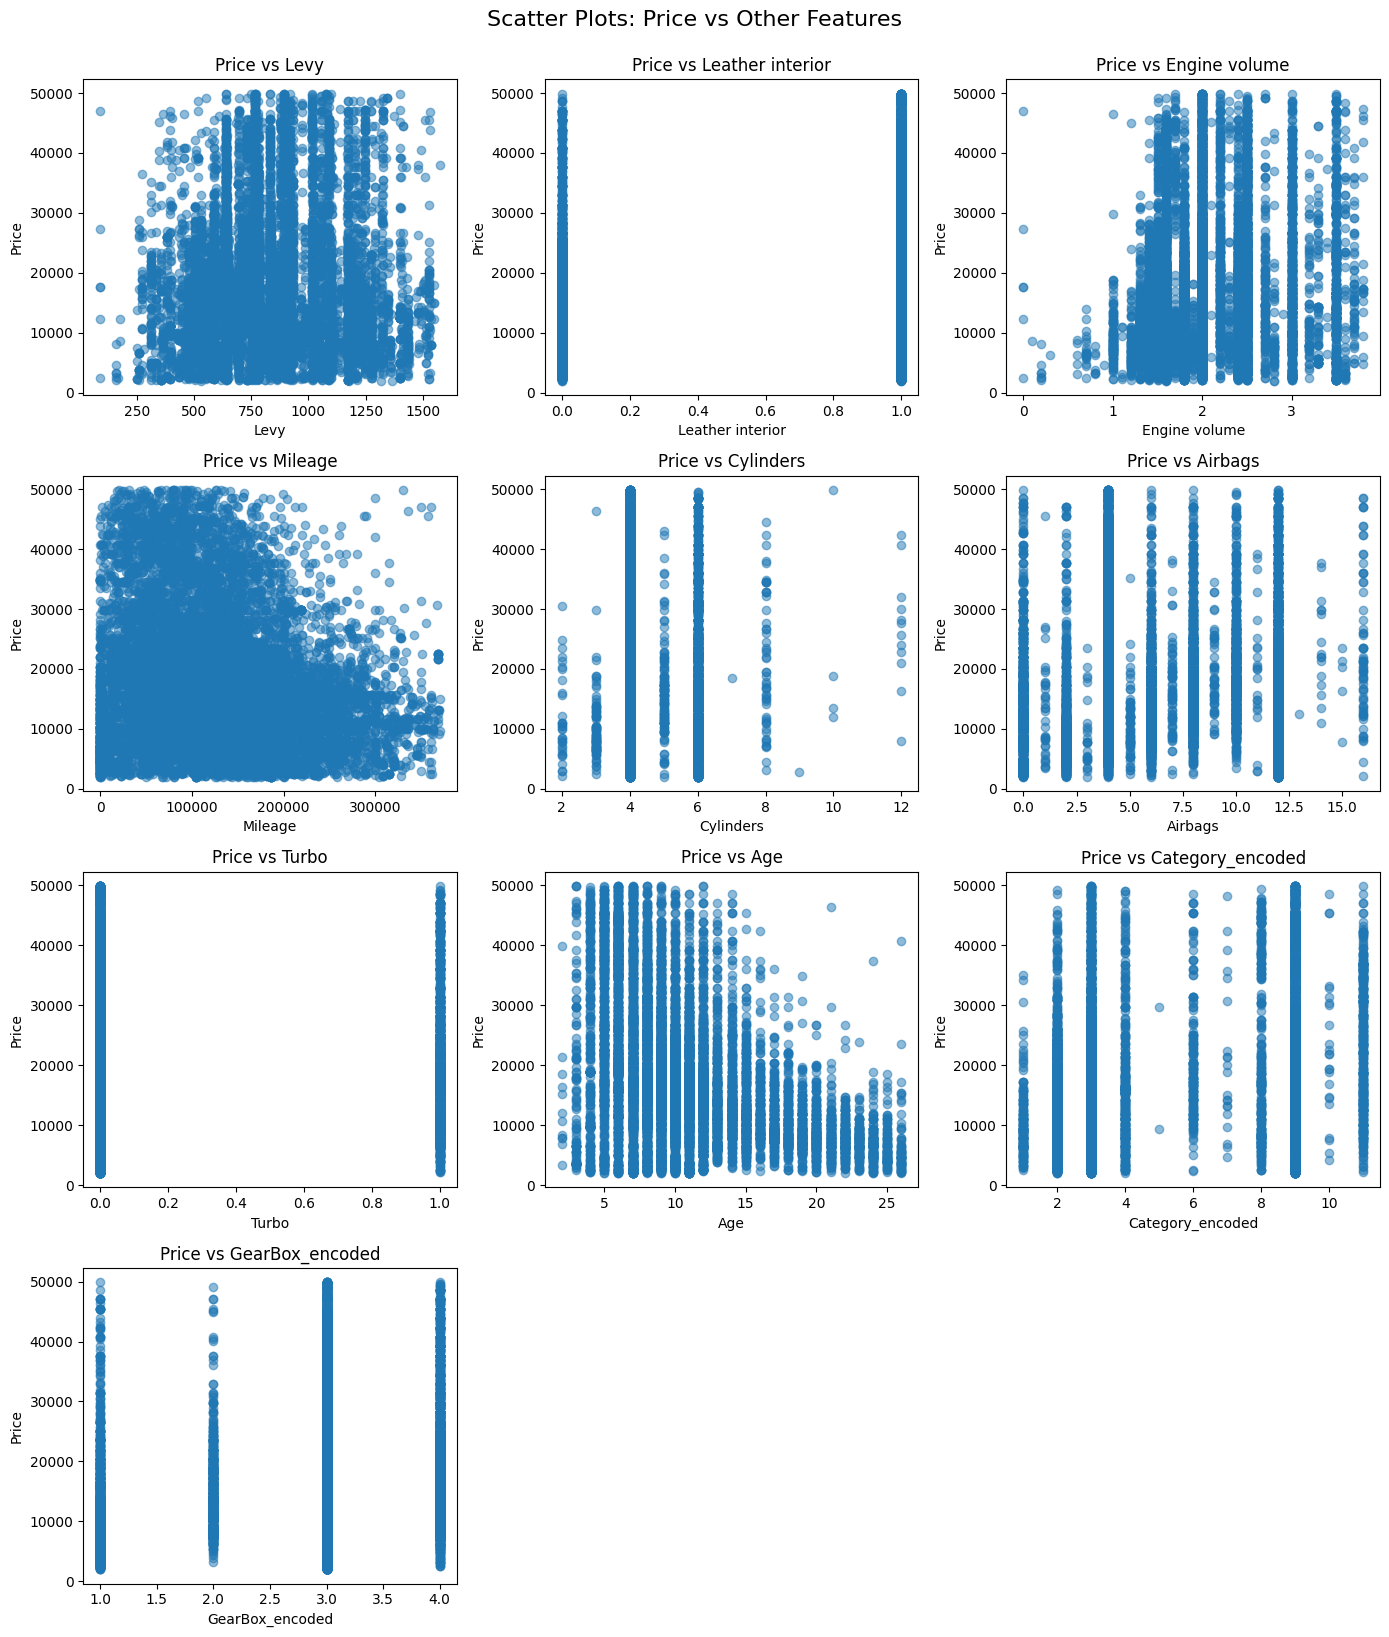

In [39]:
numeric_cols = df_baseline.select_dtypes(include=['float64', 'int64', 'int32','int64']).columns
features_to_plot = [col for col in numeric_cols if col != 'Price']

n_cols = 3
n_rows = -(-len(features_to_plot) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(features_to_plot):
    ax = axes[i]
    ax.scatter(df_baseline[col], df_baseline['Price'], alpha=0.5)
    ax.set_xlabel(col)
    ax.set_ylabel('Price')
    ax.set_title(f'Price vs {col}')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle('Scatter Plots: Price vs Other Features', fontsize=16, y=1.02)
fig.savefig(r'images\correlation_plots.png', bbox_inches='tight')
plt.show()

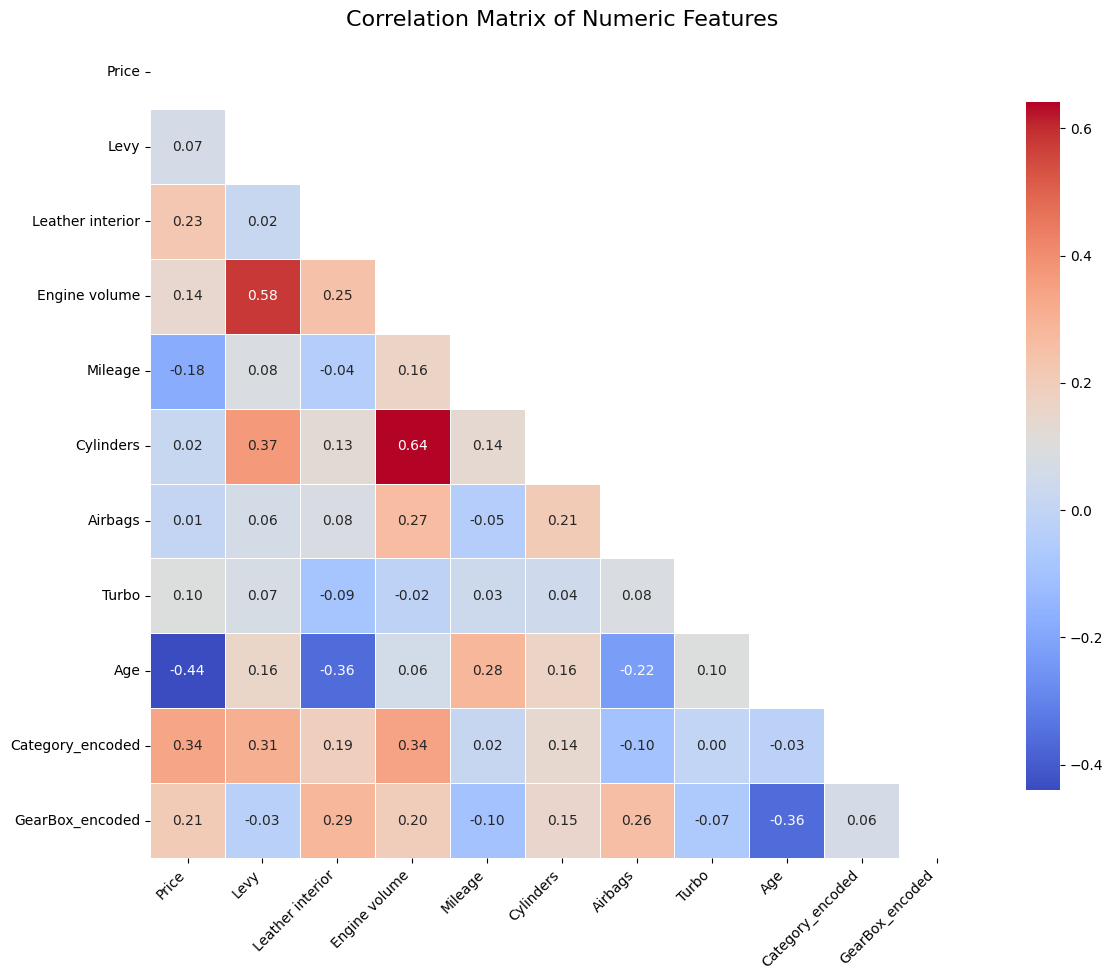

In [40]:
numeric_data = df_baseline.select_dtypes(include=[np.number])

corr = numeric_data.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

fig = plt.figure(figsize=(12, 10))

sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    square=True,
    annot_kws={"size": 10},)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Correlation Matrix of Numeric Features", fontsize=16)
plt.tight_layout()
fig.savefig(r'images\correlation_heat_plot.png', bbox_inches='tight')
plt.show()

#### Key insights:

* Price is negatively correlated with Age (-0.42). As expected, older cars tend to be significantly cheaper.

* Manufacturer and Category encodings show moderate correlation with Price. Manufacturer_encoded (-0.38) and Category_encoded (0.34) suggest your rank-based encoding reflects meaningful pricing tiers.

* Engine volume and Cylinders are strongly correlated (0.64). This is logical, as bigger engines usually have more cylinders.

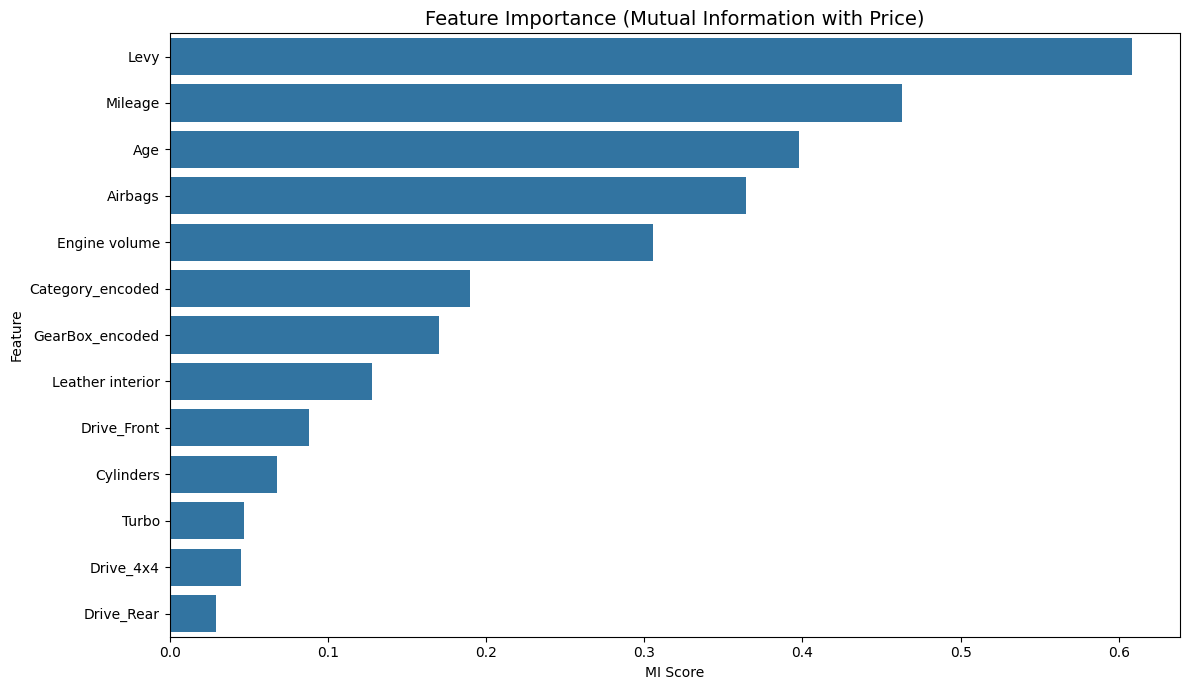

In [41]:
# Define features and target
X = df_baseline.drop(columns=[
    'Price',                # target
    'Manufacturer',         # original categorical
    'Category',
    'Gear box type',
    'Drive wheels'          # now one-hot encoded
])
y = df_baseline.loc[X.index, 'Price']  # Align y with X

# Compute mutual information
mi_scores = mutual_info_regression(X, y, discrete_features='auto')
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
# Plot
plt.figure(figsize=(12, 7))
sns.barplot(x=mi_series.values, y=mi_series.index)
plt.title("Feature Importance (Mutual Information with Price)", fontsize=14)
plt.xlabel("MI Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#### Key Insights

The above chart shows feature importance using a method called Mutual Information (MI). It's a way of measuring how much each feature in the dataset tells us about the target variable. Mutual Information measures how much knowing the value of one variable reduces uncertainty about another (e.g. mileage and price). It captures any kind of relationship, linear or nonlinear, unlike correlation which only captures linear relationships.

In our case, it looks like mileage, Levy, airbags, and age are prominent in predicting the price, as they got a higer MI score. i.e. newer cars with more airbags and bigger engines tend to be pricier. Manufacturer_encoded, and Category_encoded matter, but to a lesser degree.

### Data Preprocessing Summary

Before building a regression model, several steps were taken to clean and prepare the data:

* Dropped unnecessary columns: Features like ID, Color, Model, and Steering Wheel Side were removed because they either had too many unique values, were unlikely to influence price directly, or were redundant.

* Fixed data formatting issues: Some columns had text mixed with numbers (e.g. "km" in mileage or "Turbo" in engine volume). These were cleaned so that only numerical values remained. For instance, we also created a new column to indicate whether a car had a turbo engine.

* Converted categorical variables: Categorical features (like Leather Interior) were converted to numerical form to work with machine learning models.

* Handled missing and invalid values: Placeholder values like "-" were replaced with actual missing values (NaN) and converted to proper numerical types.

* Created a new feature for car age: Instead of using the production year directly, we calculated the car's age by subtracting the production year from the current year.

* Removed outliers: Extremely high values for price and mileage were removed because they could distort the results of the model. The cutoffs were based on distribution analysis using boxplots and interquartile range (IQR).

* Applied log transformation: Car prices and mileage were both highly skewed. Applying a logarithmic transformation helps to reduce skewness and may improve model performance by making the data more normally distributed.

* Handling Levy missing values - we created a few base groups that Levy is influenced by (engine volume, and category, engine volume, and general) and applied imputation using the median of those groups.

* Handling manufacturer, Category, and Gear box type: we turned those variables into ordinal variables based on their pattern with the price. The pattern also corresponded with believes and knowledge - for instance, a manual car is cheaper than automatic car (for gear box). for Drive wheels we decided to keep the one-hot encoding due to the insignificant prices between the 3. For the manufacturer feature, we believe that there is a strong correlation between the brand and the price. Hence, we groupped the average price by manufacturer, this captures the average value impact of each manufacturer on price, which makes intuitive sense (e.g. Mercedes vs. Hyundai). While keeping in mind this problematic feature transformation we splitted the brands into bins based on average price ranges to prevent over-fitting.

Now that we are done analyzing and processing the data, we can save it to a .csv file.

In [42]:
#Save the df_baseline to a .csv file
df_baseline.to_csv("csv_files\df_baseline.csv", index=False)

# Baseline Model: Ridge Regression

Now that the data is processed, and analyzed, we can introduce the first model for this project, Ridge regression. This model will serve as a baseline reference for the next models that we will introduce.

In [43]:
# we drop redundant original categorical columns + 1 dummy to avoid multicollinearity
cols_to_drop = ['Price', 'Category', 'Gear box type', 'Drive wheels', 'Drive_Rear']
target = np.log1p(df_baseline['Price'])

X = df_baseline.drop(columns=cols_to_drop)
y = target

#we split first before manufacturer encoding
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y, test_size=0.2, random_state=42)

# we encode Manufacturer based only on training data
manufacturer_avg_price_train = X_train.copy()
manufacturer_avg_price_train['Price'] = np.expm1(y_train) 

avg_price_by_manufacturer = manufacturer_avg_price_train.groupby('Manufacturer')['Price'].mean()
bins = [2000, 10000, 15000, 20000, 25000, 32000, float('inf')]
labels = [1, 2, 3, 4, 5, 6]
manufacturer_price_bins = pd.cut(avg_price_by_manufacturer, bins=bins, labels=labels)

# Apply encoding to both train and test
X_train['Manufacturer_encoded'] = X_train['Manufacturer'].map(manufacturer_price_bins)
X_test['Manufacturer_encoded'] = X_test['Manufacturer'].map(manufacturer_price_bins)

# Handle unknown manufacturers in test set - in case a manufacturer exists in the test but not in the train
median_bin = X_train['Manufacturer_encoded'].astype(int).median()
X_test['Manufacturer_encoded'].fillna(median_bin, inplace=True)

C:\Users\cahar\AppData\Local\Temp\ipykernel_68088\3989157354.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test['Manufacturer_encoded'].fillna(median_bin, inplace=True)


In [44]:
# Drop original 'Manufacturer' after encoding
X_train.drop(columns=['Manufacturer'], inplace=True)
X_test.drop(columns=['Manufacturer'], inplace=True)

# Standardize numeric features (excluding encoded/binary/one-hot)
ordinal_cols = ['Manufacturer_encoded', 'Category_encoded', 'GearBox_encoded']
one_hot_cols = ['Drive_4x4', 'Drive_Front']
binary_cols = ['Leather interior', 'Turbo']
to_scale = [col for col in X_train.columns if col not in ordinal_cols + one_hot_cols + binary_cols]

scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale])
X_test[to_scale] = scaler.transform(X_test[to_scale])

print("X_train shape:", X_train.shape)

X_train shape: (10428, 13)


In [45]:
# Initialize and fit Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Predict
y_pred_train = ridge_model.predict(X_train)
y_pred_test = ridge_model.predict(X_test)

# Inverse-transform predictions to original price scale
y_train_actual = np.expm1(y_train)
y_test_actual = np.expm1(y_test)
y_pred_train_actual = np.expm1(y_pred_train)
y_pred_test_actual = np.expm1(y_pred_test)

In [46]:
# we will define an evaluation function
def evaluate(y_true, y_pred, label):
    print(f"{label}")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R²:", r2_score(y_true, y_pred))
    print()

In [47]:
# and show the model evaluation
evaluate(y_train_actual, y_pred_train_actual, "Training Set")
evaluate(y_test_actual, y_pred_test_actual, "Test Set")

Training Set
MAE: 6270.219086658278
RMSE: 8584.40260195441
R²: 0.37296702679123006

Test Set
MAE: 6538.3468029811165
RMSE: 8947.302326119574
R²: 0.3385623848788831



In [48]:
# Print intercept
print(f"Intercept: {ridge_model.intercept_:.4f}")

# Print coefficients with feature names
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': ridge_model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\nTop Coefficients:")
print(coef_df.to_string(index=False))

Intercept: 8.7549

Top Coefficients:
             Feature  Coefficient
               Turbo     0.413658
                 Age    -0.258469
           Drive_4x4    -0.210029
Manufacturer_encoded     0.202672
    Leather interior    -0.182070
         Drive_Front    -0.134512
             Airbags    -0.073702
       Engine volume     0.069868
     GearBox_encoded     0.057744
    Category_encoded     0.048815
             Mileage    -0.048140
                Levy    -0.032001
           Cylinders     0.019519


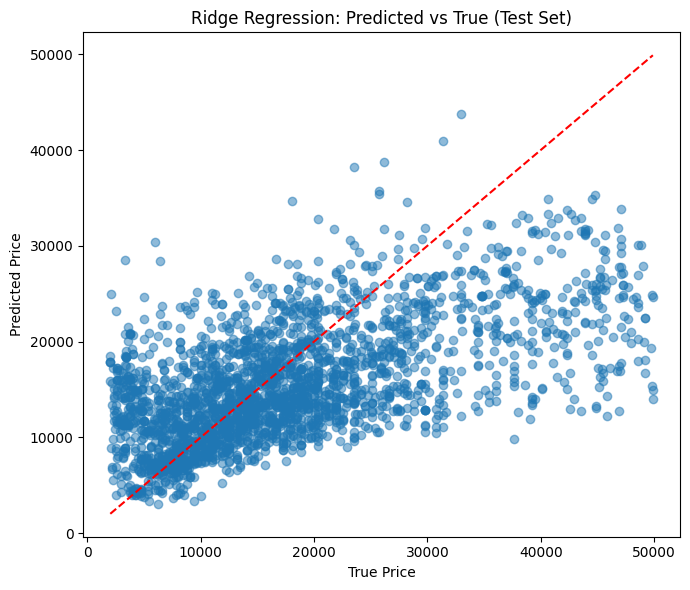

In [49]:
# Lastly we plot predictions vs true values
fig = plt.figure(figsize=(7, 6))
plt.scatter(y_test_actual, y_pred_test_actual, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("Ridge Regression: Predicted vs True (Test Set)")
plt.tight_layout()
fig.savefig(r'images\true_vs_pred_Ridge_baseline.png', bbox_inches='tight')
plt.show()

#### Key insights

* The model achieves an R_2 of =~ 0.34, meaning it explains about 34% of the variation in car prices.
* The train and test R_2 scores are nearly identical, suggesting the model is not overfitting. It generalizes reasonably well to unseen data.

* With a mean absolute error (MAE) of =~6,500, the average prediction is off by that amount. Given that the dataset includes car prices ranging from ~2,000 to 50,000.

* Underestimation of Higher Prices: The scatterplot shows the model tends to underpredict expensive cars. We assume that the linear model can’t capture complex, nonlinear relationships unless explicitly modeled.

We will try to create another model that considers the top 6 features from the MI chart:

In [50]:
# Select top MI features from already-prepared X_train and X_test
top_features = ['Levy', 'Mileage', 'Airbags', 'Age', 'Engine volume', 'Manufacturer_encoded']

X_train_top = X_train[top_features]
X_test_top = X_test[top_features]
y_train_top = y_train
y_test_top = y_test

# Train model
ridge_top = Ridge(alpha=1.0)
ridge_top.fit(X_train_top, y_train_top)

# Predict and evaluate
y_pred_top = ridge_top.predict(X_test_top)
y_test_actual = np.expm1(y_test_top)
y_pred_actual = np.expm1(y_pred_top)

print("MAE:", mean_absolute_error(y_test_actual, y_pred_actual))
print("RMSE:", np.sqrt(mean_squared_error(y_test_actual, y_pred_actual)))
print("R²:", r2_score(y_test_actual, y_pred_actual))

MAE: 6932.980117742818
RMSE: 9509.102830686556
R²: 0.252891371362825


We will try to create another model that considers the top 6 correlated (in absolut values) features from heatmap chart:

In [51]:
correlated_features = ['Age', 'Manufacturer_encoded', 'Category_encoded',
    'Leather interior', 'GearBox_encoded', 'Engine volume']

X_train_corr = X_train[correlated_features].copy()
X_test_corr = X_test[correlated_features].copy()
y_train_corr = y_train
y_test_corr = y_test

features_to_scale_corr = ['Age', 'Engine volume']
scaler_corr = StandardScaler()
X_train_corr[features_to_scale_corr] = scaler_corr.fit_transform(X_train_corr[features_to_scale_corr])
X_test_corr[features_to_scale_corr] = scaler_corr.transform(X_test_corr[features_to_scale_corr])

ridge_corr = Ridge(alpha=1.0)
ridge_corr.fit(X_train_corr, y_train_corr)

y_pred_corr = ridge_corr.predict(X_test_corr)
y_test_actual_corr = np.expm1(y_test_corr)
y_pred_actual_corr = np.expm1(y_pred_corr)

print("MAE:", mean_absolute_error(y_test_actual_corr, y_pred_actual_corr))
print("RMSE:", np.sqrt(mean_squared_error(y_test_actual_corr, y_pred_actual_corr)))
print("R²:", r2_score(y_test_actual_corr, y_pred_actual_corr))

MAE: 6758.67044919407
RMSE: 9345.265410945458
R²: 0.27841425551472565


## Bayesian models

First Model PGM

In [52]:
import pandas as pd
from pgmpy.models import BayesianNetwork, DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination
import pymc as pm
import torch



INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [53]:
df_pgm1 = df_cleaned.copy()
df_pgm1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13036 entries, 0 to 19235
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             13036 non-null  int64  
 1   Levy              13036 non-null  float64
 2   Manufacturer      13036 non-null  object 
 3   Category          13036 non-null  object 
 4   Leather interior  13036 non-null  int64  
 5   Engine volume     13036 non-null  float64
 6   Mileage           13036 non-null  int64  
 7   Cylinders         13036 non-null  float64
 8   Gear box type     13036 non-null  object 
 9   Drive wheels      13036 non-null  object 
 10  Airbags           13036 non-null  int64  
 11  Turbo             13036 non-null  int32  
 12  Age               13036 non-null  int64  
dtypes: float64(3), int32(1), int64(5), object(4)
memory usage: 1.8+ MB


Data preparation

In [54]:
from sklearn.preprocessing import StandardScaler

categorical_cols = ['Category', 'Gear box type']  # exemple

X_cat_onehot = pd.get_dummies(df_pgm1[categorical_cols]).astype(int)
X_onehot = pd.concat([df_pgm1, X_cat_onehot], axis=1)

X = X_onehot.drop(columns=['Price','Airbags','Drive wheels', 'Gear box type', 'Category','Manufacturer','Levy',],)
y = df_pgm1['Price']

#Normalisation : Maybe add Age, Cylinders, Engine Volume later
columns_to_scale =['Mileage']
scaler = StandardScaler()
print(X.columns)
X_scaled = X.copy()
X_scaled[columns_to_scale] = scaler.fit_transform(X_scaled[columns_to_scale])
X_scaled.describe()
y_scaled = y/1000


Index(['Leather interior', 'Engine volume', 'Mileage', 'Cylinders', 'Turbo',
       'Age', 'Category_Cabriolet', 'Category_Coupe', 'Category_Goods wagon',
       'Category_Hatchback', 'Category_Jeep', 'Category_Limousine',
       'Category_Microbus', 'Category_Minivan', 'Category_Pickup',
       'Category_Sedan', 'Category_Universal', 'Gear box type_Automatic',
       'Gear box type_Manual', 'Gear box type_Tiptronic',
       'Gear box type_Variator'],
      dtype='object')


Get train and test set

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2)
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)
print("X_train shape:", y_train.shape)


X_train shape: torch.Size([10428])


Define a model

In [56]:
# Linear Bayesian model y= X.w + bias + sigma

def linear_bayesian_model(X,y=None):
    N, D = X.shape  # N: nombre d'exemples, D: nombre de features
    weight = pyro.sample('weight', pyro.distributions.Normal(torch.zeros(D), torch.ones(D)).to_event(1))
    bias = pyro.sample('bias', pyro.distributions.Normal(0., 1.))
    #sigma = pyro.sample('sigma', pyro.distributions.HalfCauchy(1.0))
    sigma = 2

    mean = torch.matmul(X, weight) + bias
    with pyro.plate('data', N):
        obs = pyro.sample('obs', pyro.distributions.Normal(mean, sigma), obs=y)
    return obs

In [57]:
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam

train_elbos = []
test_elbos = []
# Define guide function
#guide = AutoDiagonalNormal(ppca_model)
guide = AutoNormal(linear_bayesian_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=3)
svi = SVI(linear_bayesian_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, y_train)
    test_loss = svi.evaluate_loss(X_test, y_test)  # évaluation (pas de mise à jour)

    train_elbos.append(elbo)
    test_elbos.append(test_loss)

    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 597563.1
[500] ELBO: 263600.8
[1000] ELBO: 204803.2
[1500] ELBO: 168847.0
[2000] ELBO: 148076.9
[2500] ELBO: 138171.1
[3000] ELBO: 134333.2
[3500] ELBO: 131635.8
[4000] ELBO: 129448.7
[4500] ELBO: 127882.3
[5000] ELBO: 126356.5
[5500] ELBO: 124896.4
[6000] ELBO: 123587.0
[6500] ELBO: 122501.4
[7000] ELBO: 121457.1
[7500] ELBO: 120559.1
[8000] ELBO: 119865.2
[8500] ELBO: 119165.5
[9000] ELBO: 118612.6
[9500] ELBO: 118148.7


Evaluate overfitting 

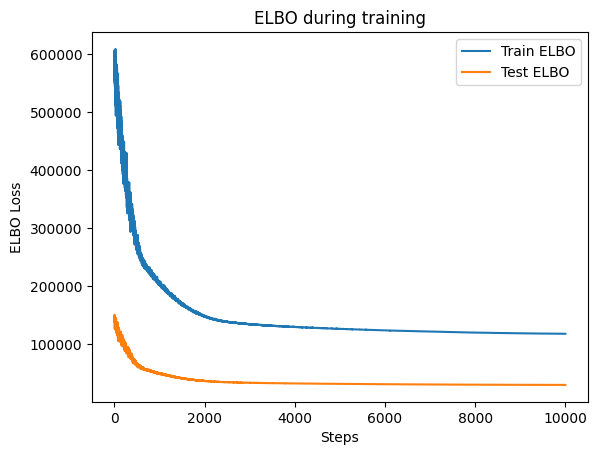

In [58]:

plt.plot(train_elbos, label="Train ELBO")
plt.plot(test_elbos, label="Test ELBO")
plt.xlabel("Steps")
plt.ylabel("ELBO Loss")
plt.legend()
plt.title("ELBO during training")
plt.show()


In [59]:
#X.columns
latent = guide(X_train)  # sample un point dans la distribution approx
weights = latent['weight'].detach().cpu().numpy()

columns = ['Leather interior', 'Engine volume', 'Mileage', 'Cylinders', 'Turbo',
       'Age', 'Manufacturer_encoded', 'Category_Cabriolet', 'Category_Coupe',
       'Category_Goods wagon', 'Category_Hatchback', 'Category_Jeep',
       'Category_Limousine', 'Category_Microbus', 'Category_Minivan',
       'Category_Pickup', 'Category_Sedan', 'Category_Universal',
       'Gear box type_Automatic', 'Gear box type_Manual',
       'Gear box type_Tiptronic', 'Gear box type_Variator']

print("Weight learned for each feature:")
for name, w in zip(columns, weights):
    print(f"{name:20s} : {w:.4f}")

# Optionnel : biais et sigma
print(f"Biais learned : {latent['bias'].item():.4f}")
#print(f"Sigma learned : {latent['sigma'].item():.4f}")

Weight learned for each feature:
Leather interior     : 1.4306
Engine volume        : 1.4408
Mileage              : -1.0111
Cylinders            : 0.4302
Turbo                : 3.5267
Age                  : -0.9347
Manufacturer_encoded : 6.8194
Category_Cabriolet   : 4.3627
Category_Coupe       : 3.3788
Category_Goods wagon : 2.3996
Category_Hatchback   : 9.1466
Category_Jeep        : 5.7999
Category_Limousine   : 9.7986
Category_Microbus    : 9.9539
Category_Minivan     : 9.2394
Category_Pickup      : 2.2368
Category_Sedan       : 10.0282
Category_Universal   : 6.1044
Gear box type_Automatic : 7.1131
Gear box type_Manual : 9.7841
Gear box type_Tiptronic : 8.6065
Biais learned : 9.9898


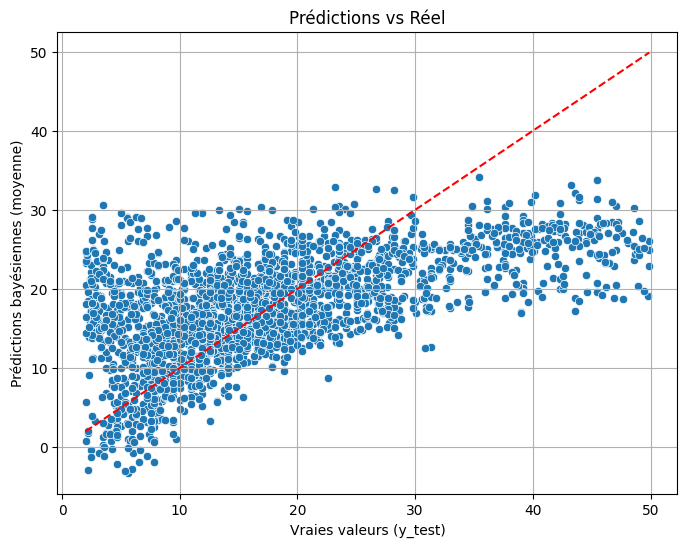

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pyro.infer import Predictive

predictive = Predictive(linear_bayesian_model, guide=guide, num_samples=1000)
samples = predictive(X_test)

# Moyenne des prédictions (shape: [batch_size])
y_pred_mean = samples["obs"].mean(0)      # moyenne bayésienne
y_pred_std = samples["obs"].std(0)        # incertitude prédictive

# y_test doit être de même type et forme
y_test_np = y_test.detach().numpy()
y_pred_np = y_pred_mean.detach().numpy()
y_std_np = y_pred_std.detach().numpy()

# Scatter plot : prédiction vs vrai
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_np, y=y_pred_np)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')  # ligne y=x
plt.xlabel("Vraies valeurs (y_test)")
plt.ylabel("Prédictions bayésiennes (moyenne)")
plt.title("Prédictions vs Réel")
plt.grid(True)
plt.show()


In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_np, y_pred_np)
rmse = torch.sqrt(torch.tensor(mse))
mae = mean_absolute_error(y_test_np, y_pred_np)
r2 = r2_score(y_test_np, y_pred_np)


print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²    : {r2:.4f}")
print("Y_std:", y_std_np)
print("Y_pred:", y_pred_np)

MAE  : 6.62
RMSE : 8.75
R²    : 0.3355
Y_std: [2.0467367 2.00425   2.0177097 ... 2.0273304 1.9799017 2.0359159]
Y_pred: [20.042244  21.142082   4.9098406 ...  6.5624495 15.586517  20.741455 ]


### Model 2

PGM

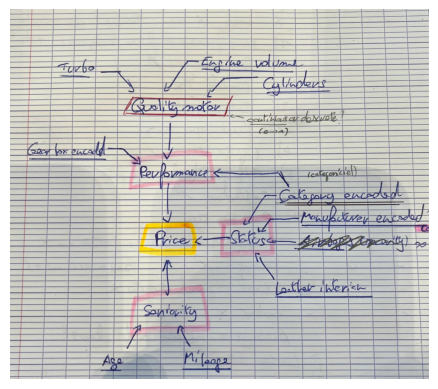

In [62]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('PGM.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

Data process

In [63]:
print(X_scaled.columns)
columns_quality = ['Turbo', 'Engine volume', 'Cylinders']
columns_seniority = ['Age', 'Mileage']
columns_performance = ['Category_Cabriolet', 'Category_Coupe',
       'Category_Goods wagon', 'Category_Hatchback', 'Category_Jeep',
       'Category_Limousine', 'Category_Microbus', 'Category_Minivan',
       'Category_Pickup', 'Category_Sedan', 'Category_Universal',
       'Gear box type_Automatic', 'Gear box type_Manual',
       'Gear box type_Tiptronic', 'Gear box type_Variator']
columns_status = ['Leather interior', 'Category_Cabriolet', 'Category_Coupe',
       'Category_Goods wagon', 'Category_Hatchback', 'Category_Jeep',
       'Category_Limousine', 'Category_Microbus', 'Category_Minivan',
       'Category_Pickup', 'Category_Sedan', 'Category_Universal']



Index(['Leather interior', 'Engine volume', 'Mileage', 'Cylinders', 'Turbo',
       'Age', 'Category_Cabriolet', 'Category_Coupe', 'Category_Goods wagon',
       'Category_Hatchback', 'Category_Jeep', 'Category_Limousine',
       'Category_Microbus', 'Category_Minivan', 'Category_Pickup',
       'Category_Sedan', 'Category_Universal', 'Gear box type_Automatic',
       'Gear box type_Manual', 'Gear box type_Tiptronic',
       'Gear box type_Variator'],
      dtype='object')


In [64]:
X_scaled_model2 =X_scaled.copy()
y_scaled_model2 = y_scaled.copy()
X_train, X_test, y_train, y_test = train_test_split(X_scaled_model2, y_scaled_model2, test_size=0.2)

X_train_quality = X_train[columns_quality]
X_train_seniority = X_train[columns_seniority]
X_train_performance = X_train[columns_performance]
print(X_train.columns)
X_train_status = X_train[columns_status]

X_test_quality = X_test[columns_quality]
X_test_seniority = X_test[columns_seniority]
X_test_performance = X_test[columns_performance]
X_test_status = X_test[columns_status]

X_train_quality = torch.tensor(X_train_quality.values, dtype=torch.float32)
X_train_performance = torch.tensor(X_train_performance.values, dtype=torch.float32)
X_train_status = torch.tensor(X_train_status.values, dtype=torch.float32)
X_train_seniority = torch.tensor(X_train_seniority.values, dtype=torch.float32)

X_test_quality = torch.tensor(X_test_quality.values, dtype=torch.float32)
X_test_performance = torch.tensor(X_test_performance.values, dtype=torch.float32)
X_test_status = torch.tensor(X_test_status.values, dtype=torch.float32)
X_test_seniority = torch.tensor(X_test_seniority.values, dtype=torch.float32)

y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

Index(['Leather interior', 'Engine volume', 'Mileage', 'Cylinders', 'Turbo',
       'Age', 'Category_Cabriolet', 'Category_Coupe', 'Category_Goods wagon',
       'Category_Hatchback', 'Category_Jeep', 'Category_Limousine',
       'Category_Microbus', 'Category_Minivan', 'Category_Pickup',
       'Category_Sedan', 'Category_Universal', 'Gear box type_Automatic',
       'Gear box type_Manual', 'Gear box type_Tiptronic',
       'Gear box type_Variator'],
      dtype='object')


In [65]:
import pyro.distributions

#Latent deterministic for now
def model2(X_quality, X_performance, X_status, X_seniority, y=None):
    N = X_quality.shape[0]

    # Quality latent
    D_q = X_quality.shape[1]
    w_q = pyro.sample("w_quality", pyro.distributions.Normal(torch.zeros(D_q), torch.ones(D_q)).to_event(1))
    b_q = pyro.sample("b_quality", pyro.distributions.Normal(0., 1.))
    quality_latent = torch.matmul(X_quality, w_q) + b_q

    # Performance latent conditionné sur quality
    D_p = X_performance.shape[1]
    w_p_x = pyro.sample("w_performance_x", pyro.distributions.Normal(torch.zeros(D_p), torch.ones(D_p)).to_event(1))
    w_p_q = pyro.sample("w_performance_q", pyro.distributions.Normal(0., 1.))  # pondère quality_latent
    b_p = pyro.sample("b_performance", pyro.distributions.Normal(0., 1.))
    performance_latent = torch.matmul(X_performance, w_p_x) + w_p_q * quality_latent + b_p

    # Status
    D_s = X_status.shape[1]
    w_s = pyro.sample("w_status", pyro.distributions.Normal(torch.zeros(D_s), torch.ones(D_s)).to_event(1))
    b_s = pyro.sample("b_status", pyro.distributions.Normal(0., 1.))
    status_latent = torch.matmul(X_status, w_s) + b_s

    # Seniority
    D_se = X_seniority.shape[1]
    w_se = pyro.sample("w_seniority", pyro.distributions.Normal(torch.zeros(D_se), torch.ones(D_se)).to_event(1))
    b_se = pyro.sample("b_seniority", pyro.distributions.Normal(0., 1.))
    seniority_latent = torch.matmul(X_seniority, w_se) + b_se

    # Global linear combination
    w_perf = pyro.sample("w_perf", pyro.distributions.Normal(0., 1.))
    w_stat = pyro.sample("w_stat", pyro.distributions.Normal(0., 1.))
    w_sen = pyro.sample("w_sen", pyro.distributions.Normal(0., 1.))
    b_global = pyro.sample("bias_global", pyro.distributions.Normal(0., 1.))
    #sigma = pyro.sample("sigma", pyro.distributions.HalfCauchy(1.))
    sigma =1

    global_mean = (
        quality_latent +  # directement inclus
        w_perf * performance_latent +
        w_stat * status_latent +
        w_sen * seniority_latent +
        b_global
    )

    with pyro.plate("data", N):
        obs=pyro.sample("obs", pyro.distributions.Normal(global_mean, sigma), obs=y)
    return obs


In [66]:
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam

train_elbos = []
test_elbos = []
# Define guide function
#guide = AutoDiagonalNormal(ppca_model)
guide = AutoNormal(model2)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 5000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=3)
svi = SVI(model2, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_quality, X_train_performance, X_train_status, X_train_seniority, y_train)
    test_loss = svi.evaluate_loss(X_test_quality, X_test_performance, X_test_status, X_test_seniority, y_test)  # évaluation (pas de mise à jour)

    train_elbos.append(elbo)
    test_elbos.append(test_loss)

    if step % 100 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 2234462.2
[100] ELBO: 2040241.3
[200] ELBO: 1921212.4
[300] ELBO: 1773103.8
[400] ELBO: 1535160.0
[500] ELBO: 1338488.7
[600] ELBO: 1034456.1
[700] ELBO: 896174.7
[800] ELBO: 759630.9
[900] ELBO: 692166.4
[1000] ELBO: 666009.6
[1100] ELBO: 643100.9
[1200] ELBO: 622861.4
[1300] ELBO: 603753.0
[1400] ELBO: 587828.0
[1500] ELBO: 559814.8
[1600] ELBO: 539325.0
[1700] ELBO: 516769.4
[1800] ELBO: 494982.0
[1900] ELBO: 476822.8
[2000] ELBO: 471723.8
[2100] ELBO: 463509.0
[2200] ELBO: 453716.1
[2300] ELBO: 469327.7
[2400] ELBO: 449793.2
[2500] ELBO: 445421.0
[2600] ELBO: 440609.0
[2700] ELBO: 441416.5
[2800] ELBO: 439081.1
[2900] ELBO: 433551.5
[3000] ELBO: 432708.5
[3100] ELBO: 430788.8
[3200] ELBO: 431589.8
[3300] ELBO: 427764.3
[3400] ELBO: 427573.4
[3500] ELBO: 427930.9
[3600] ELBO: 423918.8
[3700] ELBO: 422026.0
[3800] ELBO: 423487.1
[3900] ELBO: 421146.5
[4000] ELBO: 418917.9
[4100] ELBO: 417379.9
[4200] ELBO: 416926.1
[4300] ELBO: 416000.4
[4400] ELBO: 414827.3
[4500] ELBO: 41

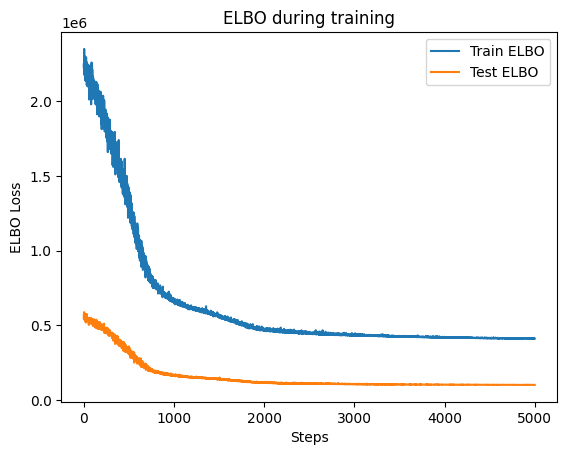

Weight learned for each feature:
Turbo                : 1.7840
Engine volume        : 0.5741
Cylinders            : 0.3413
Category_Cabriolet   : 1.7139
Category_Coupe       : 1.1918
Category_Goods wagon : 0.6110
Category_Hatchback   : 0.4555
Category_Jeep        : 2.3682
Category_Limousine   : 4.2910
Category_Microbus    : 3.0318
Category_Minivan     : 2.9694
Category_Pickup      : 2.8940
Category_Sedan       : 0.4407
Category_Universal   : 2.9302
Gear box type_Automatic : 0.7845
Gear box type_Manual : 2.0439
Gear box type_Tiptronic : 3.2985
Gear box type_Variator : 2.6972
Quality : 0.6278158
Leather interior     : 0.6629
Category_Cabriolet   : 1.9095
Category_Coupe       : 1.0587
Category_Goods wagon : 0.5522
Category_Hatchback   : 0.4237
Category_Jeep        : 2.2706
Category_Limousine   : 5.1573
Category_Microbus    : 2.8562
Category_Minivan     : 2.9312
Category_Pickup      : 2.9035
Category_Sedan       : 0.2964
Category_Universal   : 2.8704
Age                  : 0.7662
Mileage  

In [67]:

plt.plot(train_elbos, label="Train ELBO")
plt.plot(test_elbos, label="Test ELBO")
plt.xlabel("Steps")
plt.ylabel("ELBO Loss")
plt.legend()
plt.title("ELBO during training")
plt.show()

#X.columns
latent = guide(X_train_quality, X_train_performance, X_train_status, X_train_seniority)  # sample un point dans la distribution approx
weights_quality = latent['w_quality'].detach().cpu().numpy()
weights_status = latent['w_status'].detach().cpu().numpy()
weights_seniority = latent['w_seniority'].detach().cpu().numpy()
weights_performance = latent['w_performance_x'].detach().cpu().numpy()
weights_performance_q = latent['w_performance_q'].detach().cpu().numpy()


print("Weight learned for each feature:")
for name, w in zip(columns_quality, weights_quality):
    print(f"{name:20s} : {w:.4f}")
for name, w in zip(columns_performance, weights_performance):
    print(f"{name:20s} : {w:.4f}")
print("Quality :", weights_performance_q)
for name, w in zip(columns_status, weights_status):
    print(f"{name:20s} : {w:.4f}")
for name, w in zip(columns_seniority, weights_seniority):
    print(f"{name:20s} : {w:.4f}")

# Optionnel : biais et sigma
#print(f"Biais learned : {latent['bias'].item():.4f}")
#print(f"Sigma learned : {latent['sigma'].item():.4f}")


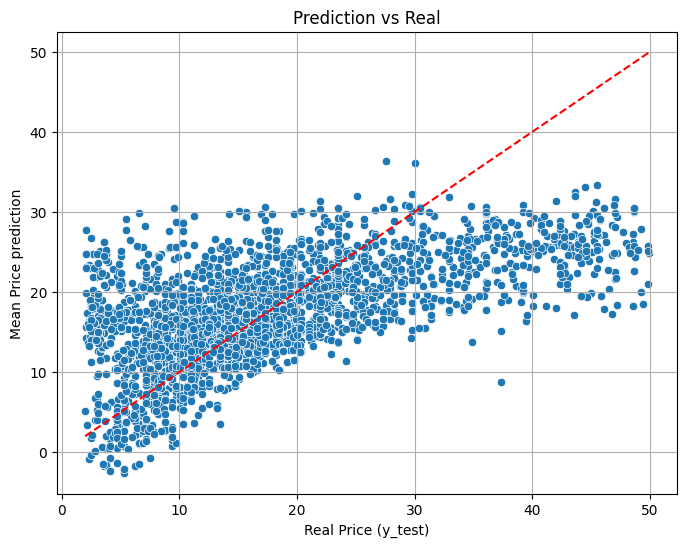

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pyro.infer import Predictive

predictive = Predictive(model2, guide=guide, num_samples=1000)
samples = predictive(X_test_quality, X_test_performance, X_test_status, X_test_seniority)

# Moyenne des prédictions (shape: [batch_size])
y_pred_mean = samples["obs"].mean(0)      # moyenne bayésienne
y_pred_std = samples["obs"].std(0)        # incertitude prédictive

# y_test doit être de même type et forme
y_test_np = y_test.detach().numpy()
y_pred_np = y_pred_mean.detach().numpy()
y_std_np = y_pred_std.detach().numpy()

# Scatter plot : prédiction vs vrai
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_np, y=y_pred_np)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')  # ligne y=x
plt.xlabel("Real Price (y_test)")
plt.ylabel("Mean Price prediction")
plt.title("Prediction vs Real")
plt.grid(True)
plt.show()

In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_np, y_pred_np)
rmse = torch.sqrt(torch.tensor(mse))
mae = mean_absolute_error(y_test_np, y_pred_np)
r2 = r2_score(y_test_np, y_pred_np)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²    : {r2:.4f}")
print("Y_std:", y_std_np)
print("Y_pred:", y_pred_np)


MAE  : 6.58
RMSE : 8.71
R²    : 0.3616
Y_std: [1.080467  1.0673878 1.0615398 ... 1.0689085 1.0518124 1.1043477]
Y_pred: [18.350832 24.849966 14.384319 ... 18.102907 24.050558 29.770123]
